# **Anomaly detection and Predictive maintenance for industrial devices: Predictive Maintenance**

**Stefano Meza Anzules** <br>
**2070772**

## Task 3

*Convert the alarms from their integer encoding to their bit string and then identify
correctly the required alarms.* <br>
*Once the alarms have been identified find some possible correlation between the
variables and those alarms.* <br>
*With the figured out correlations, try to predict an alarm in the future. E.g: given
a set of correlated features (variable) at time Ti−1 try to predict if at time Ti there
will a fault or not*

# Section A: Packages and Pyspark Session

## *Libraries and packages*

In [1]:
import numpy as np
import os
import pandas as pd
import pyspark
import seaborn as sns
from pyspark.sql.functions import unix_timestamp, from_unixtime, transform, hour, mean, month, weekofyear, dayofmonth, year, sum, avg, max, min, count, var_pop, var_samp, expr, to_date, lit
import matplotlib.pyplot as plt
from pyspark.sql.functions import col , to_date
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *

#Create functions
#convert integer to 16 binary number
convert_int_to_bin = udf(lambda x: format(x, "016b"))
#take j bit position of a binary number
take_bit = udf(lambda x, j: str(x)[-j])

spark.stop()

## *Spark Session*

In [2]:
from pyspark.sql import SparkSession

def create_spark_session(app_name, exe_memory, exe_cores, num_executors):

    # Create Spark Session
    spark = SparkSession.builder \
        .master("spark://10.67.22.50:7077") \
        .appName(app_name) \
        .config("spark.executor.memory", exe_memory) \
        .config("spark.executor.instances", num_executors) \
        .config("spark.executor.cores", exe_cores) \
        .getOrCreate()
    
    return spark

# Configuration parameters
app_name = "Spark Analysis C"
executor_memory = "1g"  # 6GB per executor
executor_cores = 2      # Utilize 6 cores per executor
num_executors = 12 

# Create Spark session    
spark = create_spark_session(app_name, executor_memory, executor_cores, num_executors)

# Set Spark Context object
sc = spark.sparkContext

# Section B: Data loading and exploration

## *Load data*

In [3]:
spark.sparkContext.setJobGroup("group1", "Loading Data")
n_cores = 3*8
total_size = 5000
desired_size = 100
optimal_npartitions = total_size/desired_size

# Load your data here
raw_data = spark.read.option("inferSchema", "true").option("header", "true").csv("5aeff182-52ab-46d3-af1d-57ac75b3a21e.csv")
refined_data = raw_data.select(from_unixtime(col("when")/1000).alias("time"), "metric", "value", "hwid")

## *Alarm conversion*

In [4]:
spark.sparkContext.setJobGroup("group1", "Refining Data")

# Create new dataframe with only the following metrics: A5 and A9
alarms_data = refined_data.filter((col("metric") =="A5") | (col("metric") =="A9"))
# Show the number of data points of each alarm for each device
alarms_data.groupBy("metric", "hwid").count().show()
# Convert the alarm value into a 16 binary number
alarms_data = alarms_data.withColumn("binary", convert_int_to_bin(col("value")))
# Extraxt 6th, 7th and 8th bit and create new column with them
alarms_data = (alarms_data.withColumn("sensor_6", take_bit(col("binary"),lit(6) ).cast("boolean"))
                          .withColumn("sensor_7", take_bit(col("binary"),lit(7) ).cast("boolean"))
                          .withColumn("sensor_8", take_bit(col("binary"),lit(8) ).cast("boolean"))
                          .drop("binary", "value"))

# Now we mut create a time window, as there is not much data available, let's use daily measurements. If there is
# more that one measurement in a day (0, 1) in an alarm, we take the maximum. We just care if it was an overheating
# in the engines. 
alarms_data = alarms_data.groupBy([dayofmonth("time").alias("day"), month("time").alias("month"), year("time").alias("year"), col("metric"), col("hwid")]) \
.agg(max("sensor_6").alias("max_6"), \
     max("sensor_7").alias("max_7"), \
     max("sensor_8").alias("max_8"), \
    ) \
.orderBy("year", "month", "day")

# Convert time columns into a more concise column 
alarms_data = alarms_data.withColumn("time",concat_ws("-",col("year"),col("month"),col("day")).cast("date")).drop("day", "month", "year")

# Create new dataframe with daily dates from October 1st to March 31. It will be used later
start_date = "2020-10-01"
end_date = "2021-03-31"
all_time = spark.createDataFrame([(start_date, end_date)], ["start_date", "end_date"])
all_time = all_time.selectExpr("explode(sequence(to_date(start_date), to_date(end_date))) as date")    

+------+------+-----+
|metric|  hwid|count|
+------+------+-----+
|    A5|SW-088|  217|
|    A9|SW-088|  305|
|    A9|SW-106|   92|
|    A5|SW-106|   92|
|    A5|SW-065|  155|
|    A9|SW-065|  155|
|    A9|SW-115|  129|
|    A5|SW-115|  187|
+------+------+-----+



# Section C: Devices and alarm analysis

Once the values of A5 and A9 have been converted into binary numbers (representing the sensors) and the postprocessing part is already finished (agregation and time slicing) we can proceed to the next step.

Let's show the behaviour of the alarms in each device separately. As we do not have much information about the engines and the correlation between the devices, our approach is to analyze one by one.

## *Device SW-106 | A5*

In [5]:
spark.sparkContext.setJobGroup("group2", "Device 1")

# First we choose the hwid SW-106 and its A5 values 
SW_106_A5 = alarms_data.filter((col("hwid") == "SW-106") & (col("metric") == "A5")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_106_A5 = all_time.join(SW_106_A5, all_time.date == SW_106_A5.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_106_A5 = SW_106_A5.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})

In [6]:
def plotting_alarms(device, alarm, df):
    y_labels_alarm = np.array([0,1])
    labels_alarm = ["normal", "overheating"]
    alarms = ["max_6", "max_7", "max_8"]
    bit = ["6", "7", "8"]
    fig, axis = plt.subplots(3, 1, figsize = (20,20))
    
    for i in range(3):
        axis[i].plot(df["date"],df[alarms[i]], "k.", markersize=20)
        axis[i].set_title(f"{alarm} bit {bit[i]} - {device} evolution")
        axis[i].set_xlabel("1 oct 2020 - 31 mar 2021")
        axis[i].set_ylabel("Alarm status")
        axis[i].set_yticks(y_labels_alarm, labels_alarm)

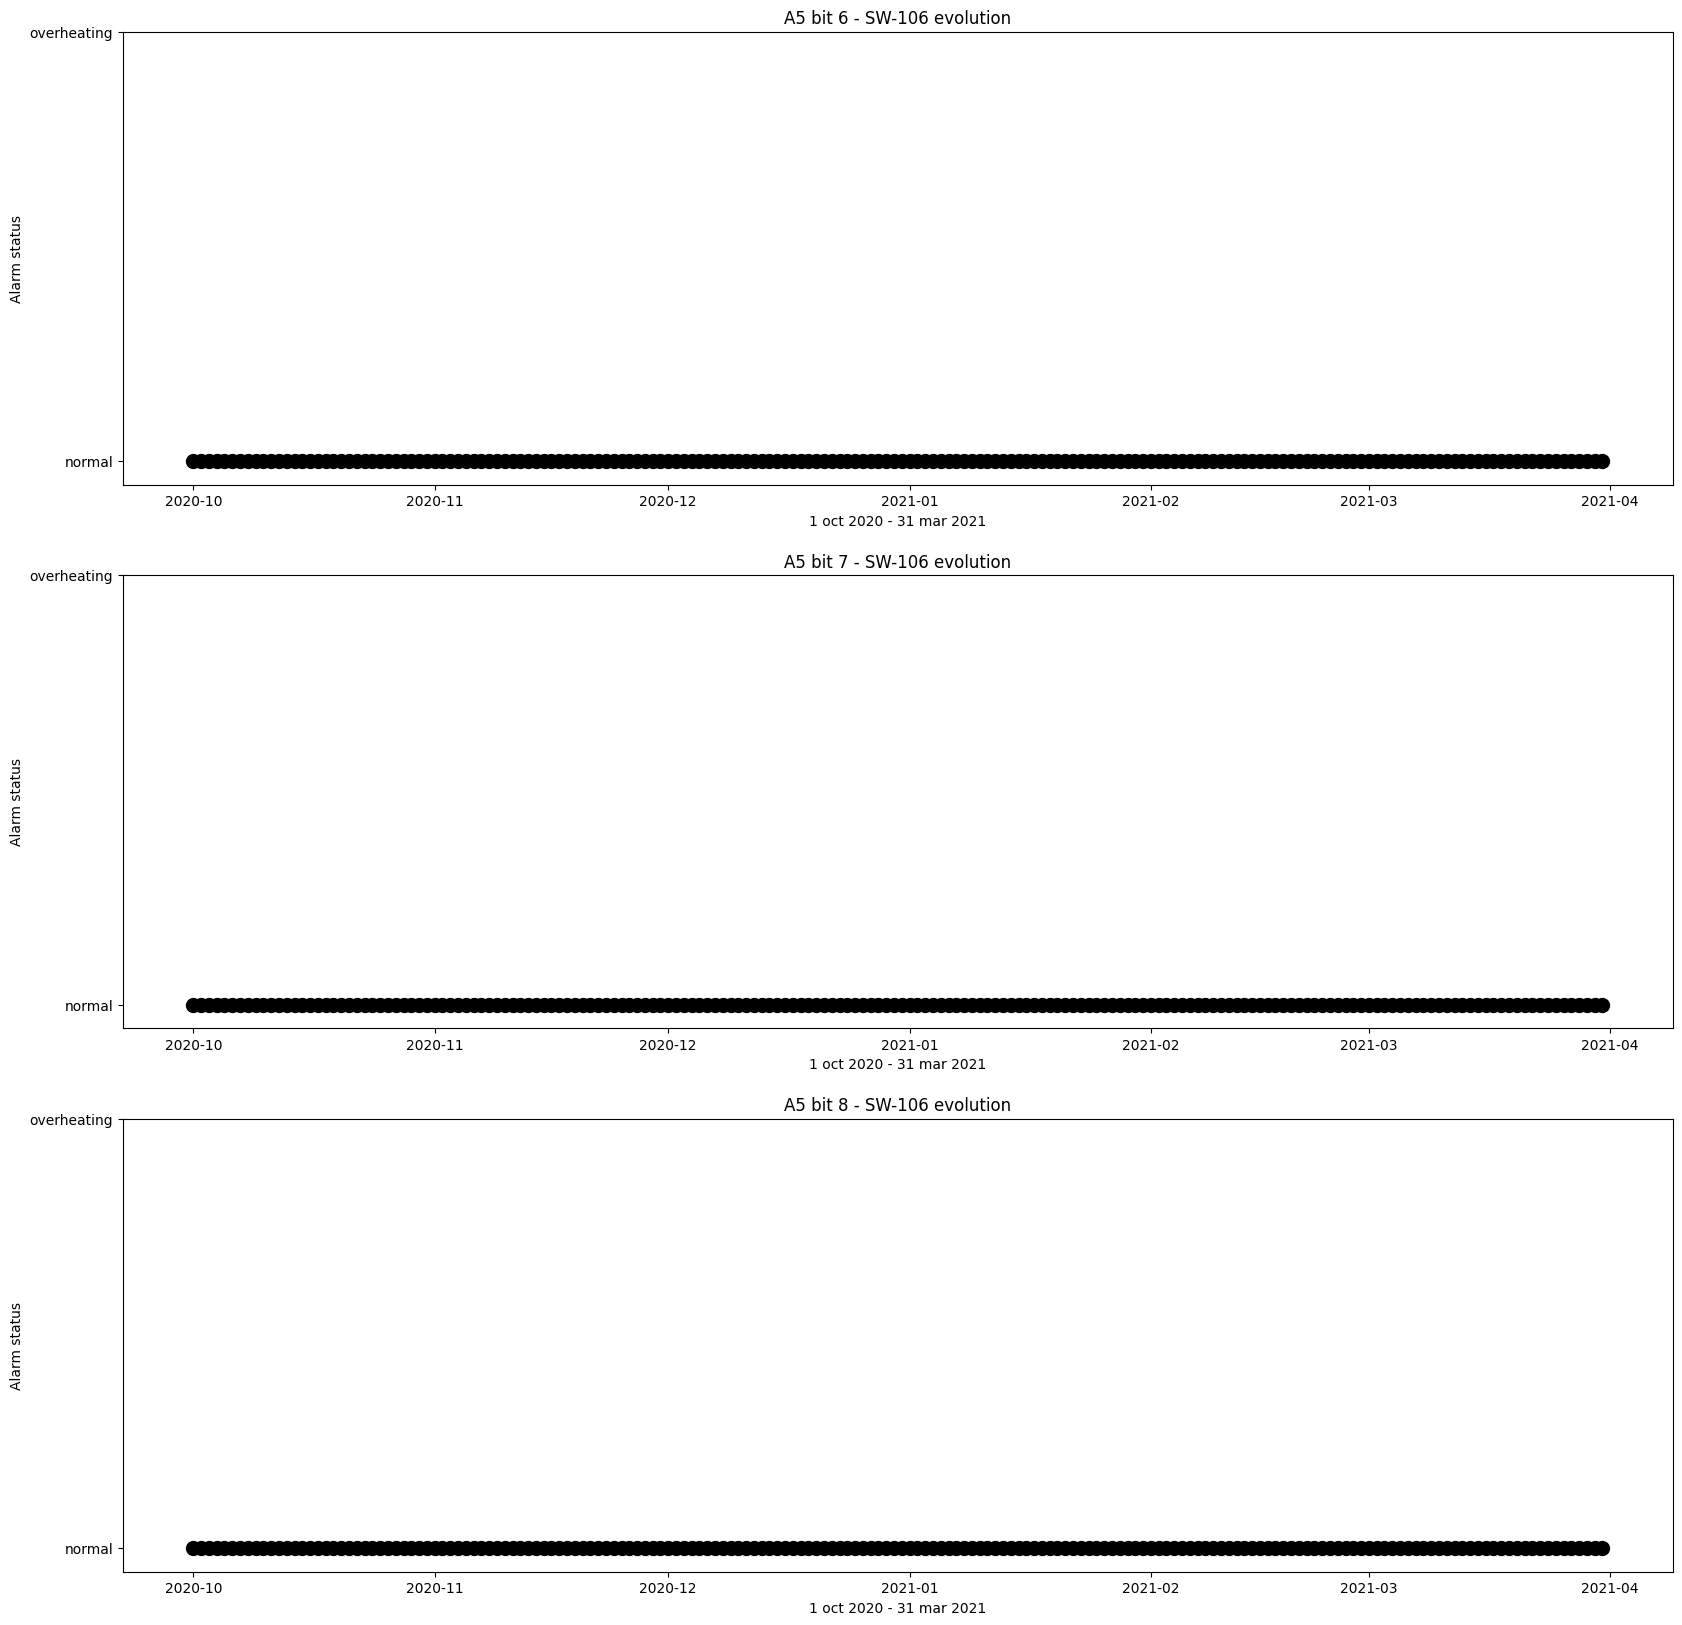

In [7]:
plotting_alarms("SW-106", "A5", SW_106_A5.toPandas())

Here, we can see that the device worked perfectly without any failure (no overheating). Therefore we proceed to analyse the next alarm.

In [8]:
# Release resources
SW_106_A5 = None

## Device *SW-106 | A9*

In [9]:
# First we choose the hwid SW-106 and its A5 values 
SW_106_A9 = alarms_data.filter((col("hwid") == "SW-106") & (col("metric") == "A9")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_106_A9 = all_time.join(SW_106_A9, all_time.date == SW_106_A9.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_106_A9 = SW_106_A9.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})

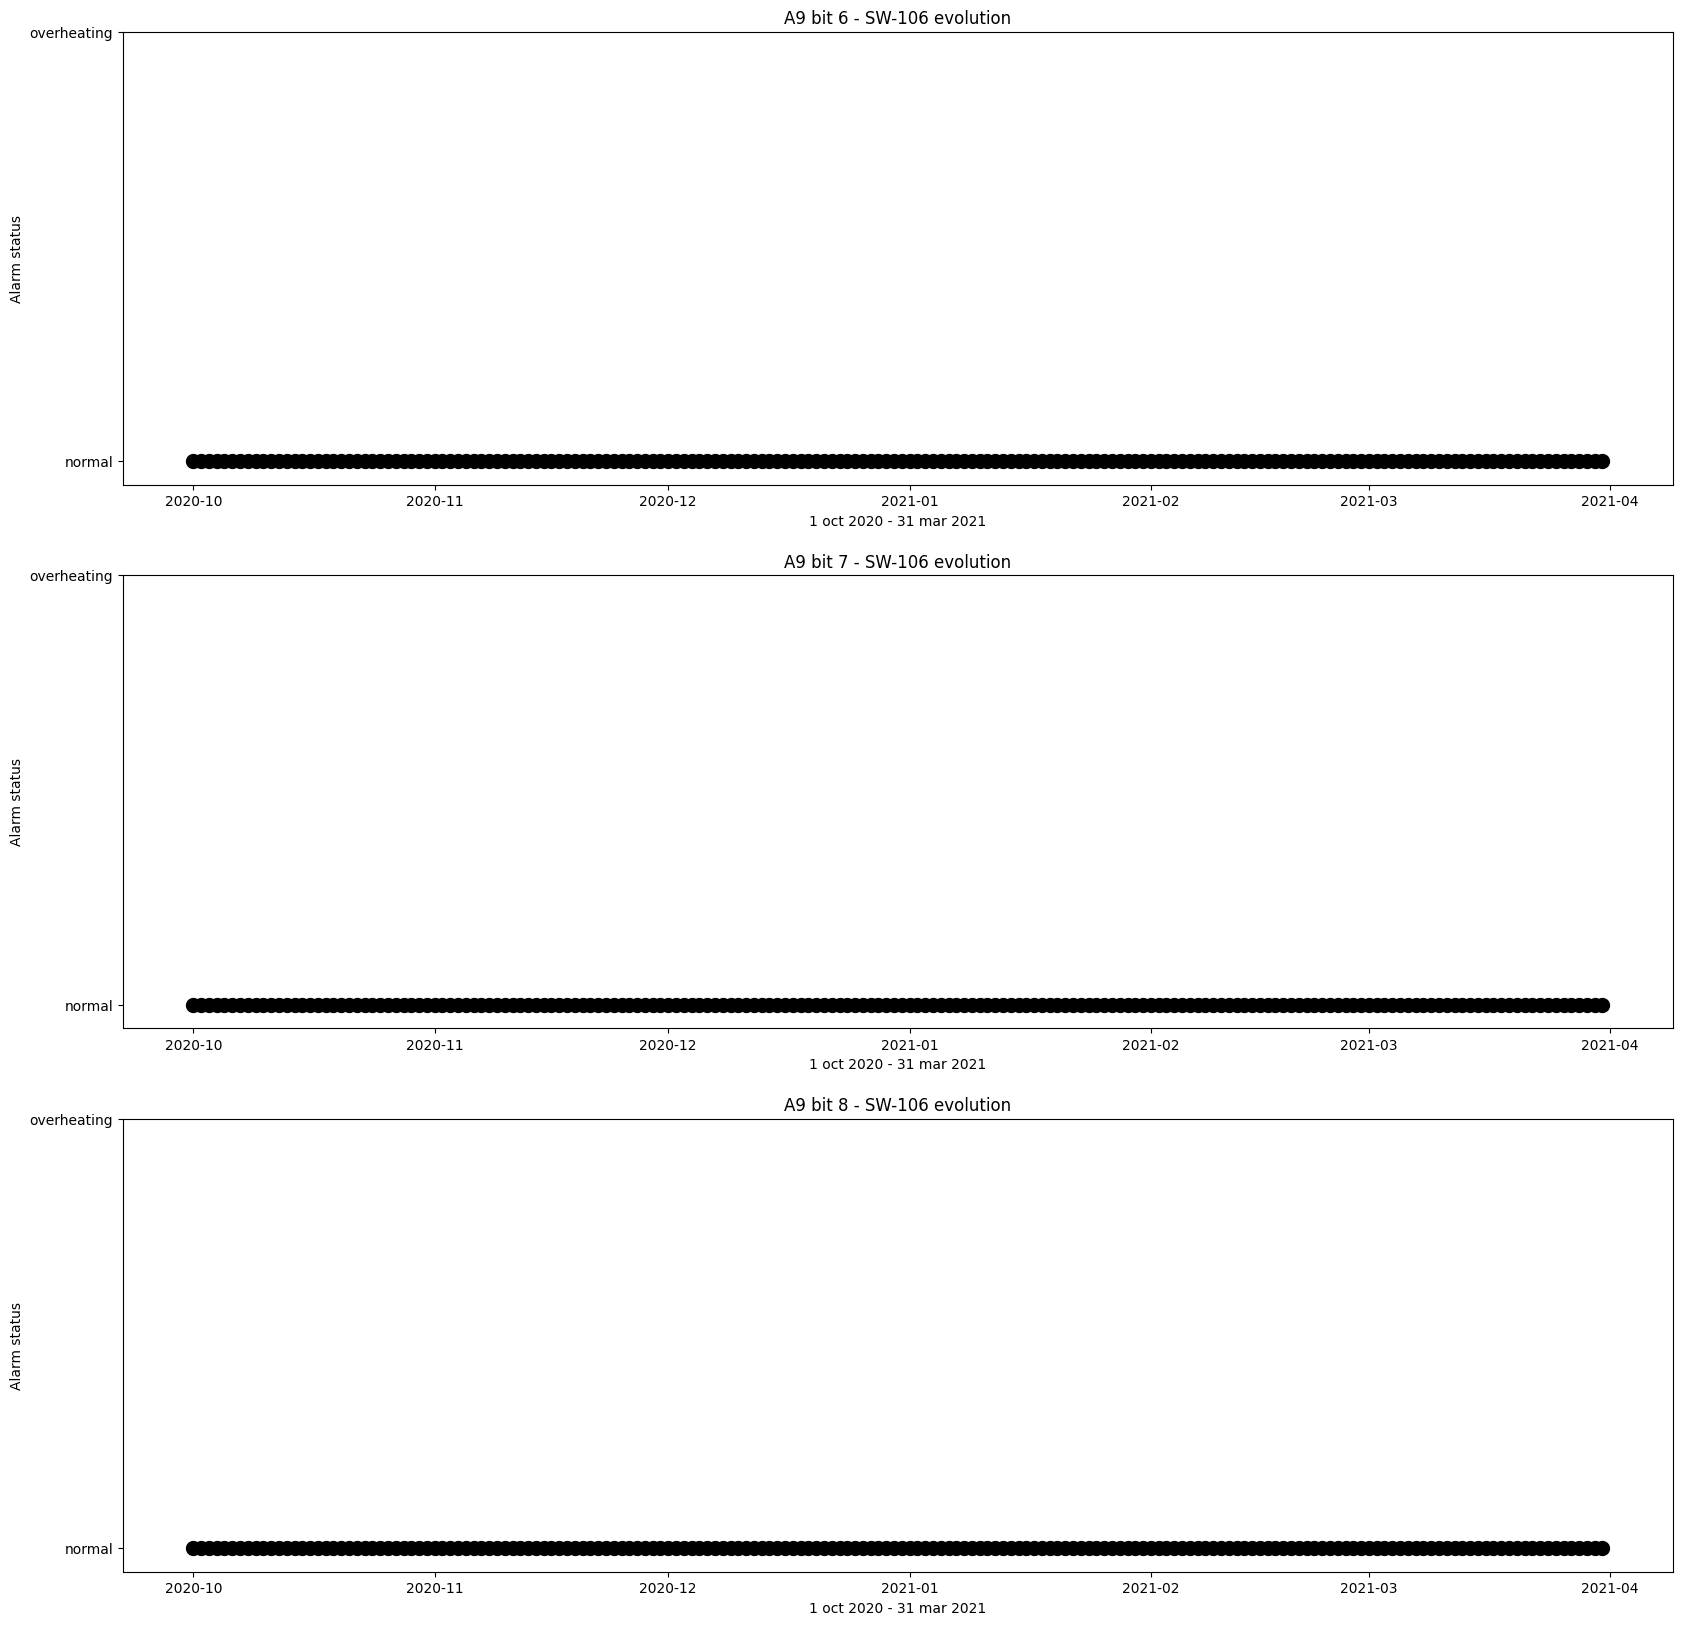

In [10]:
plotting_alarms("SW-106", "A9", SW_106_A9.toPandas())

Here, we can see that the device worked perfectly without any failure (no overheating). Then we can conclude the analysis for the device SW-106. Let's proceed to the next device.

In [11]:
# Release resources
SW_106_A9 = None

## *Device SW-115 | A5*

In [12]:
spark.sparkContext.setJobGroup("group2", "Device 2")

# First we choose the hwid SW-115 and its A5 values 
SW_115_A5 = alarms_data.filter((col("hwid") == "SW-115") & (col("metric") == "A5")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_115_A5 = all_time.join(SW_115_A5, all_time.date == SW_115_A5.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_115_A5 = SW_115_A5.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})

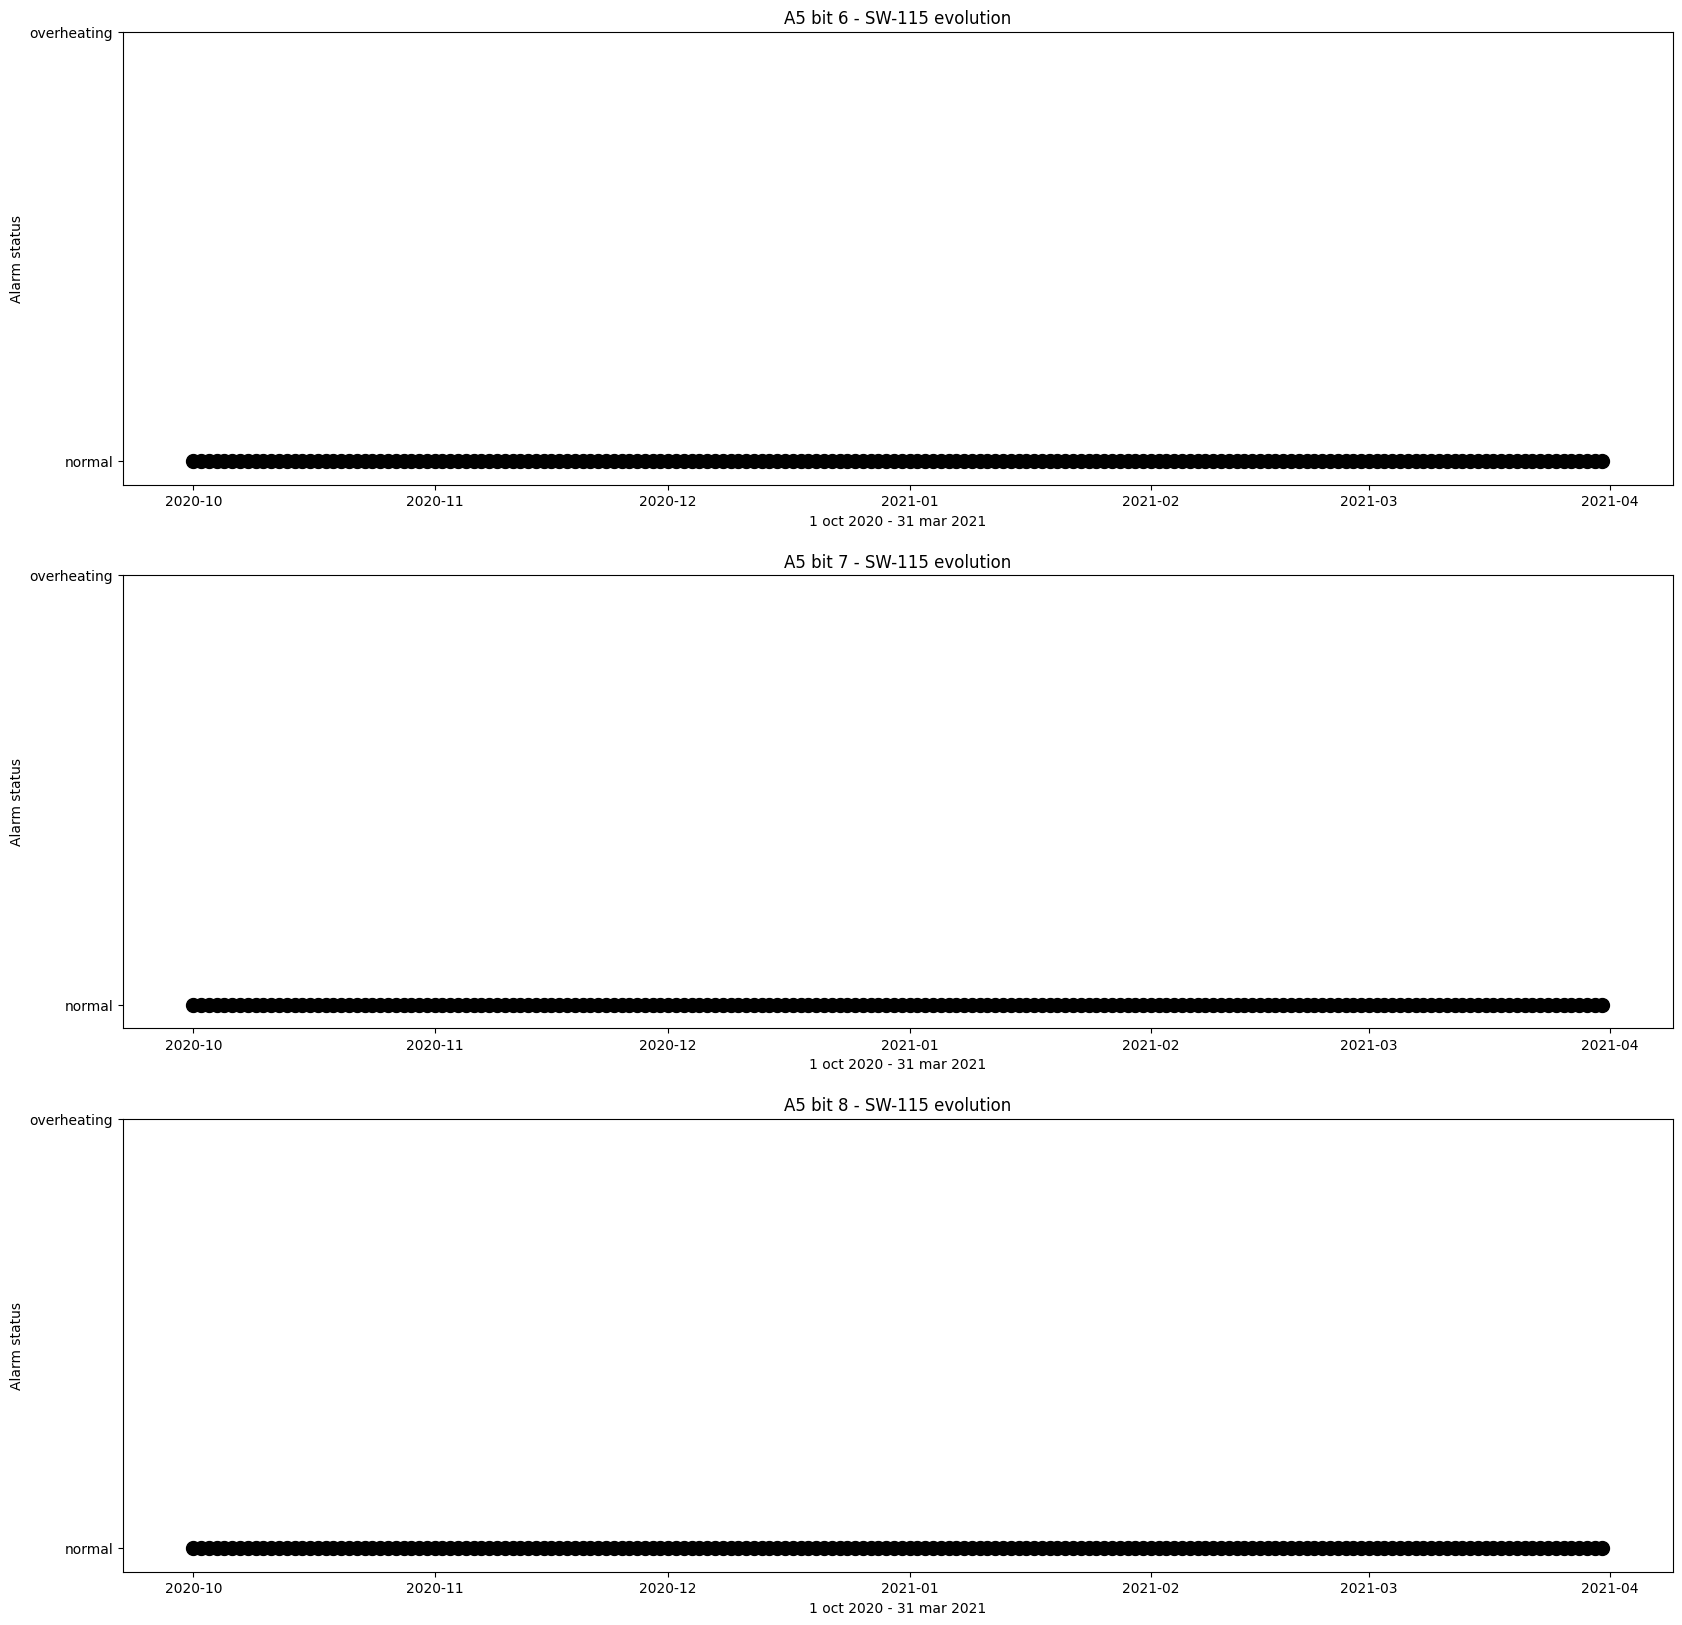

In [13]:
plotting_alarms("SW-115", "A5", SW_115_A5.toPandas())

Here, we can see that the device worked perfectly without any failure (no overheating). Therefore we proceed to analyse the next alarm.

In [14]:
# Release resources
SW_115_A5 = None

## *Device SW-115 | A9*

In [15]:
# First we choose the hwid SW-115 and its A9 values 
SW_115_A9 = alarms_data.filter((col("hwid") == "SW-115") & (col("metric") == "A9")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_115_A9 = all_time.join(SW_115_A9, all_time.date == SW_115_A9.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_115_A9 = SW_115_A9.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})

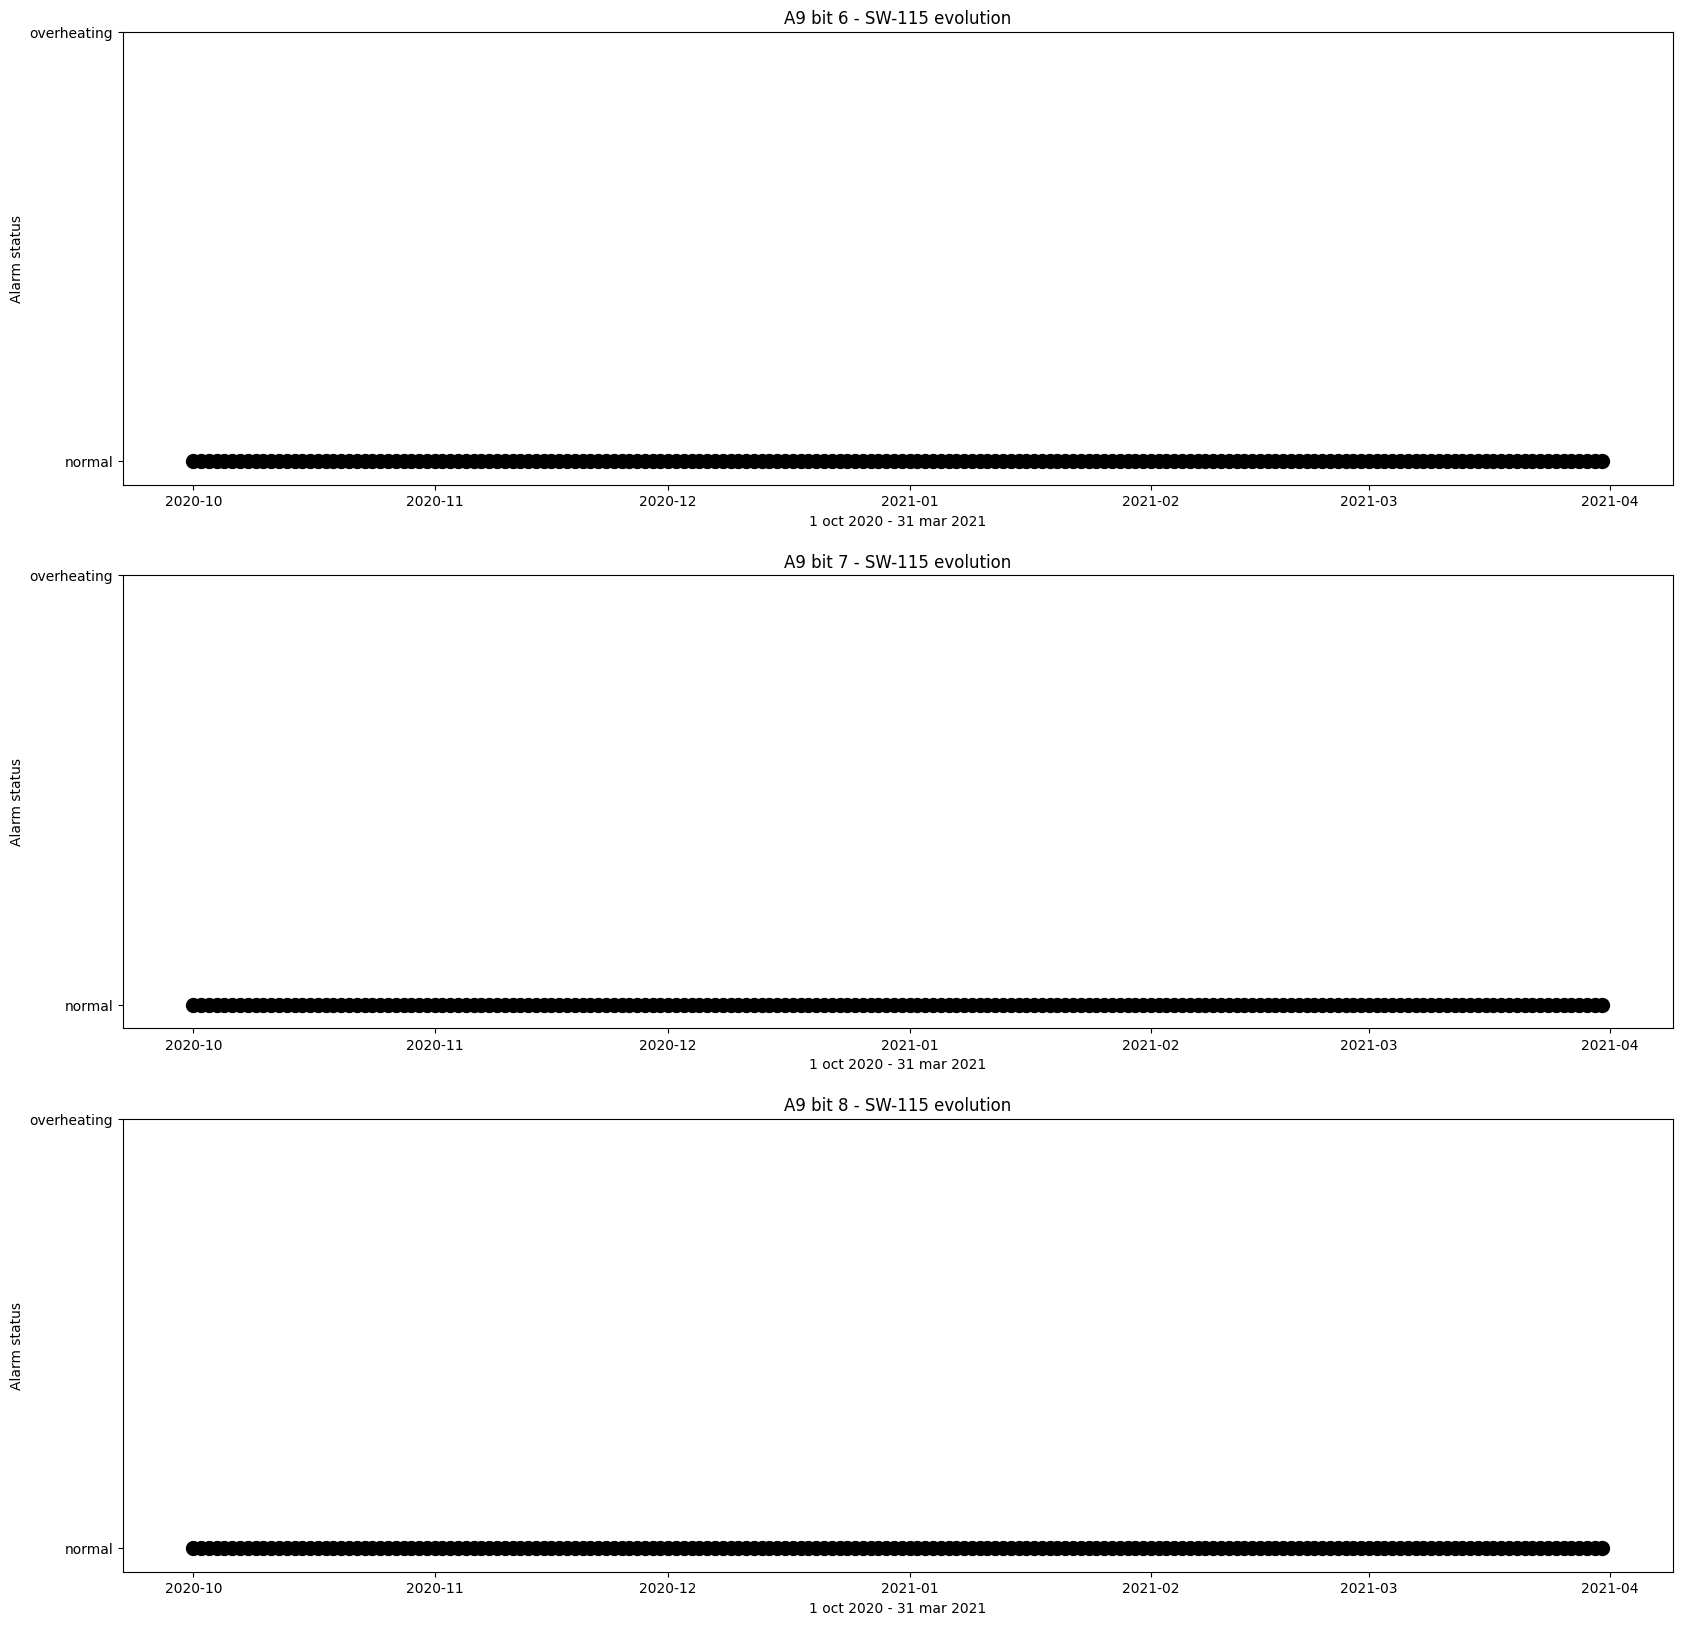

In [16]:
plotting_alarms("SW-115", "A9", SW_115_A9.toPandas())

Here, we can see that the device worked perfectly without any failure (no overheating). Then we can conclude the analysis for the device SW-106. Let's proceed to the next device.

In [17]:
# Release resources
SW_115_A9 = None

## *Device SW-065 | A5*

In [18]:
spark.sparkContext.setJobGroup("group2", "Device 3")

# First we choose the hwid SW-065 and its A5 values 
SW_065_A5 = alarms_data.filter((col("hwid") == "SW-065") & (col("metric") == "A5")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_065_A5 = all_time.join(SW_065_A5, all_time.date == SW_065_A5.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_065_A5 = SW_065_A5.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})

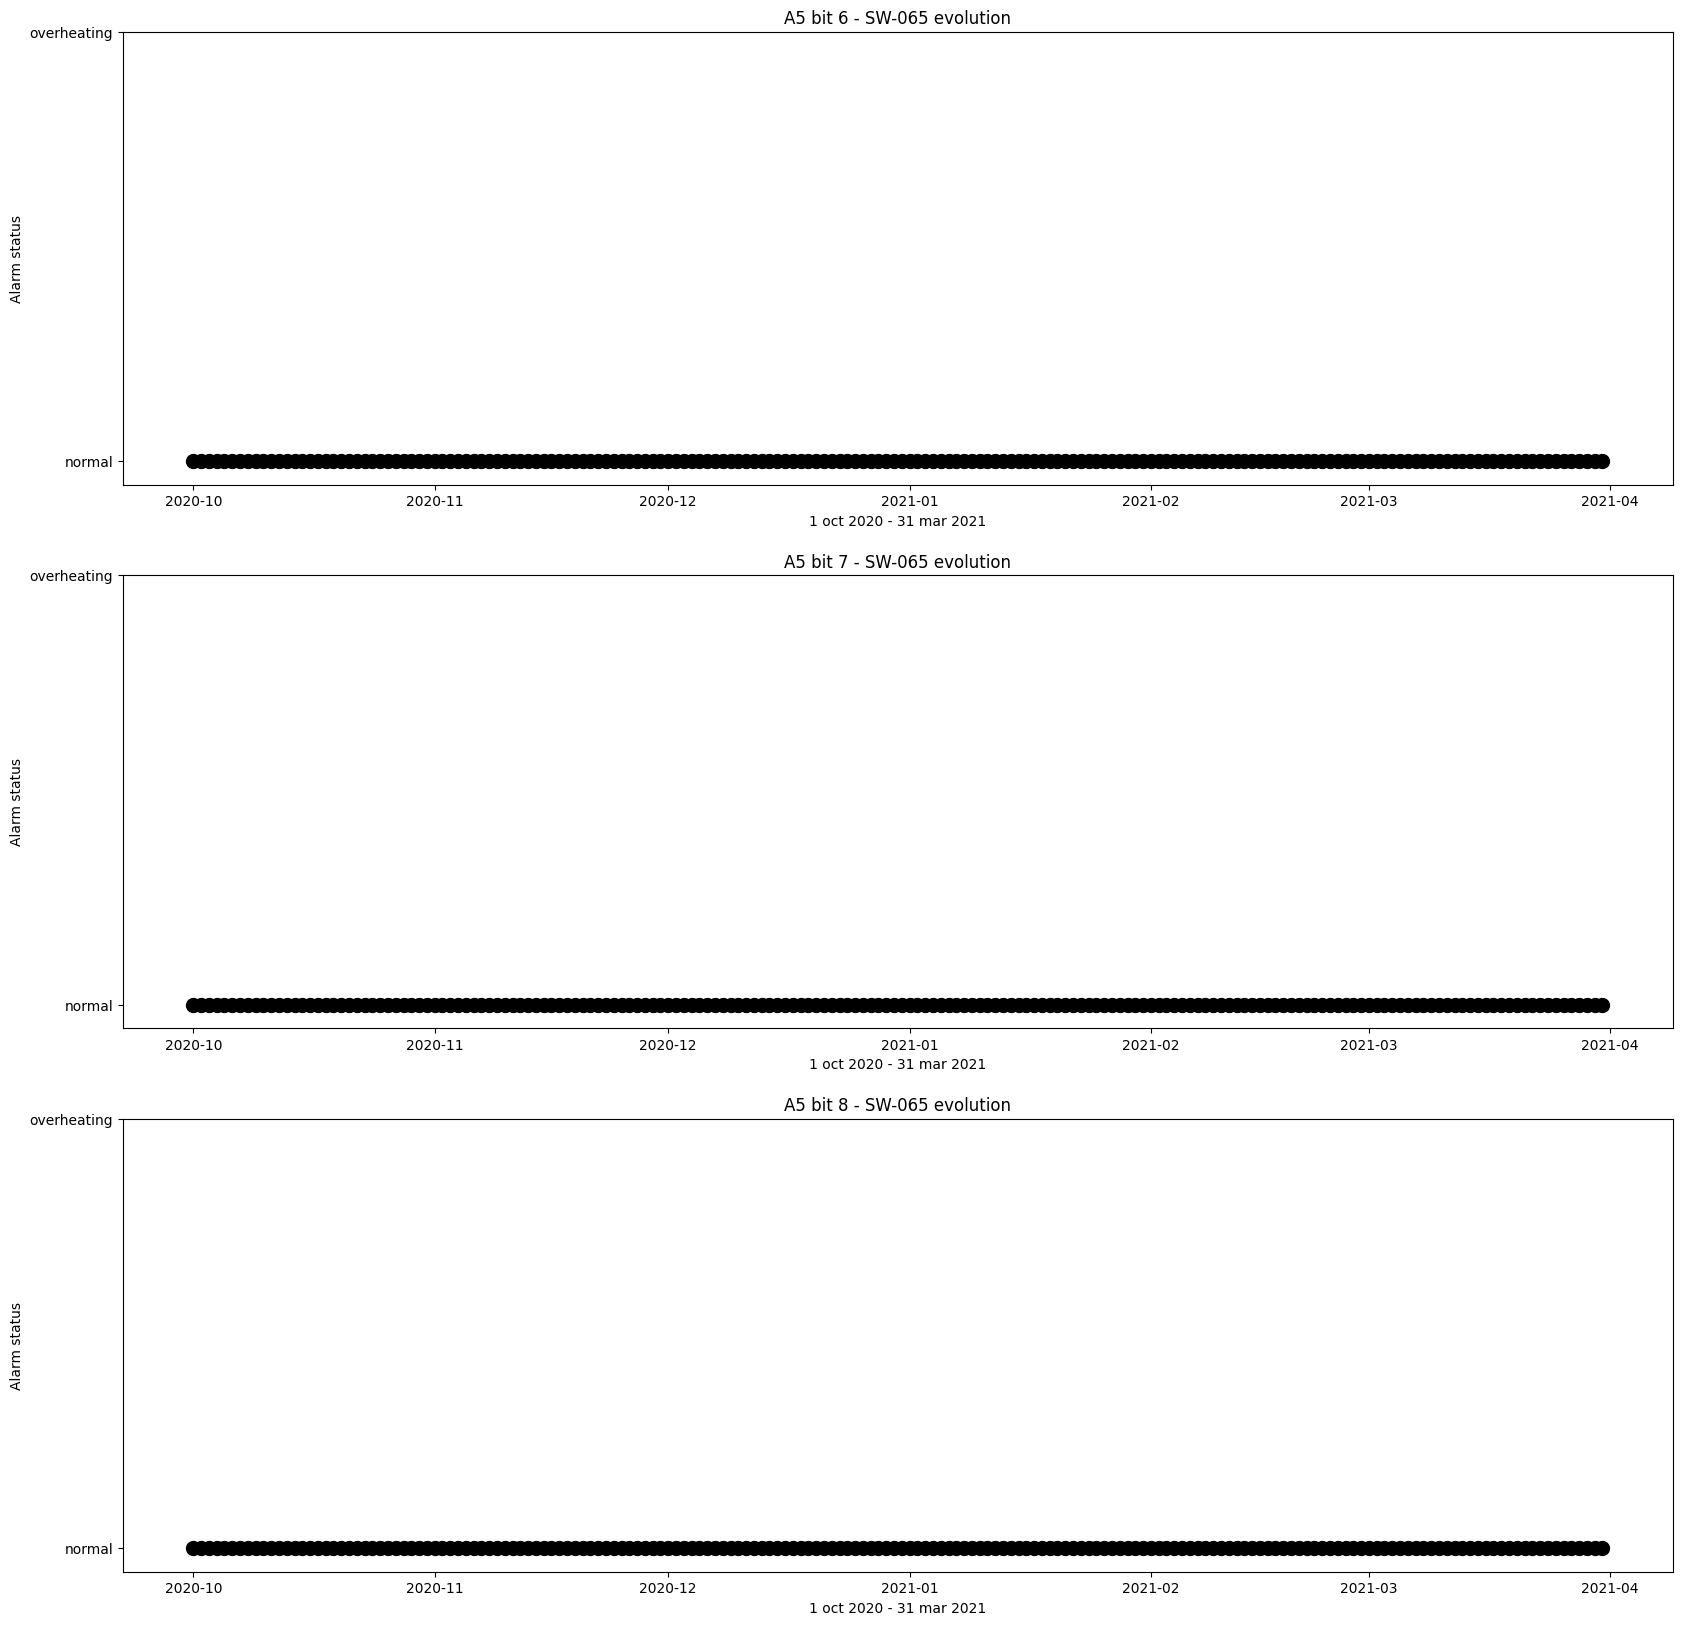

In [19]:
plotting_alarms("SW-065", "A5", SW_065_A5.toPandas())

Here, we can see that the device worked perfectly without any failure (no overheating). Therefore we proceed to analyse the next alarm

In [20]:
# Release resources
SW_065_A5 = None

## Device *SW-065 | A9*

In [21]:
# First we choose the hwid SW-165 and its A9 values 
SW_065_A9 = alarms_data.filter((col("hwid") == "SW-065") & (col("metric") == "A9")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_065_A9 = all_time.join(SW_065_A9, all_time.date == SW_065_A9.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_065_A9 = SW_065_A9.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})

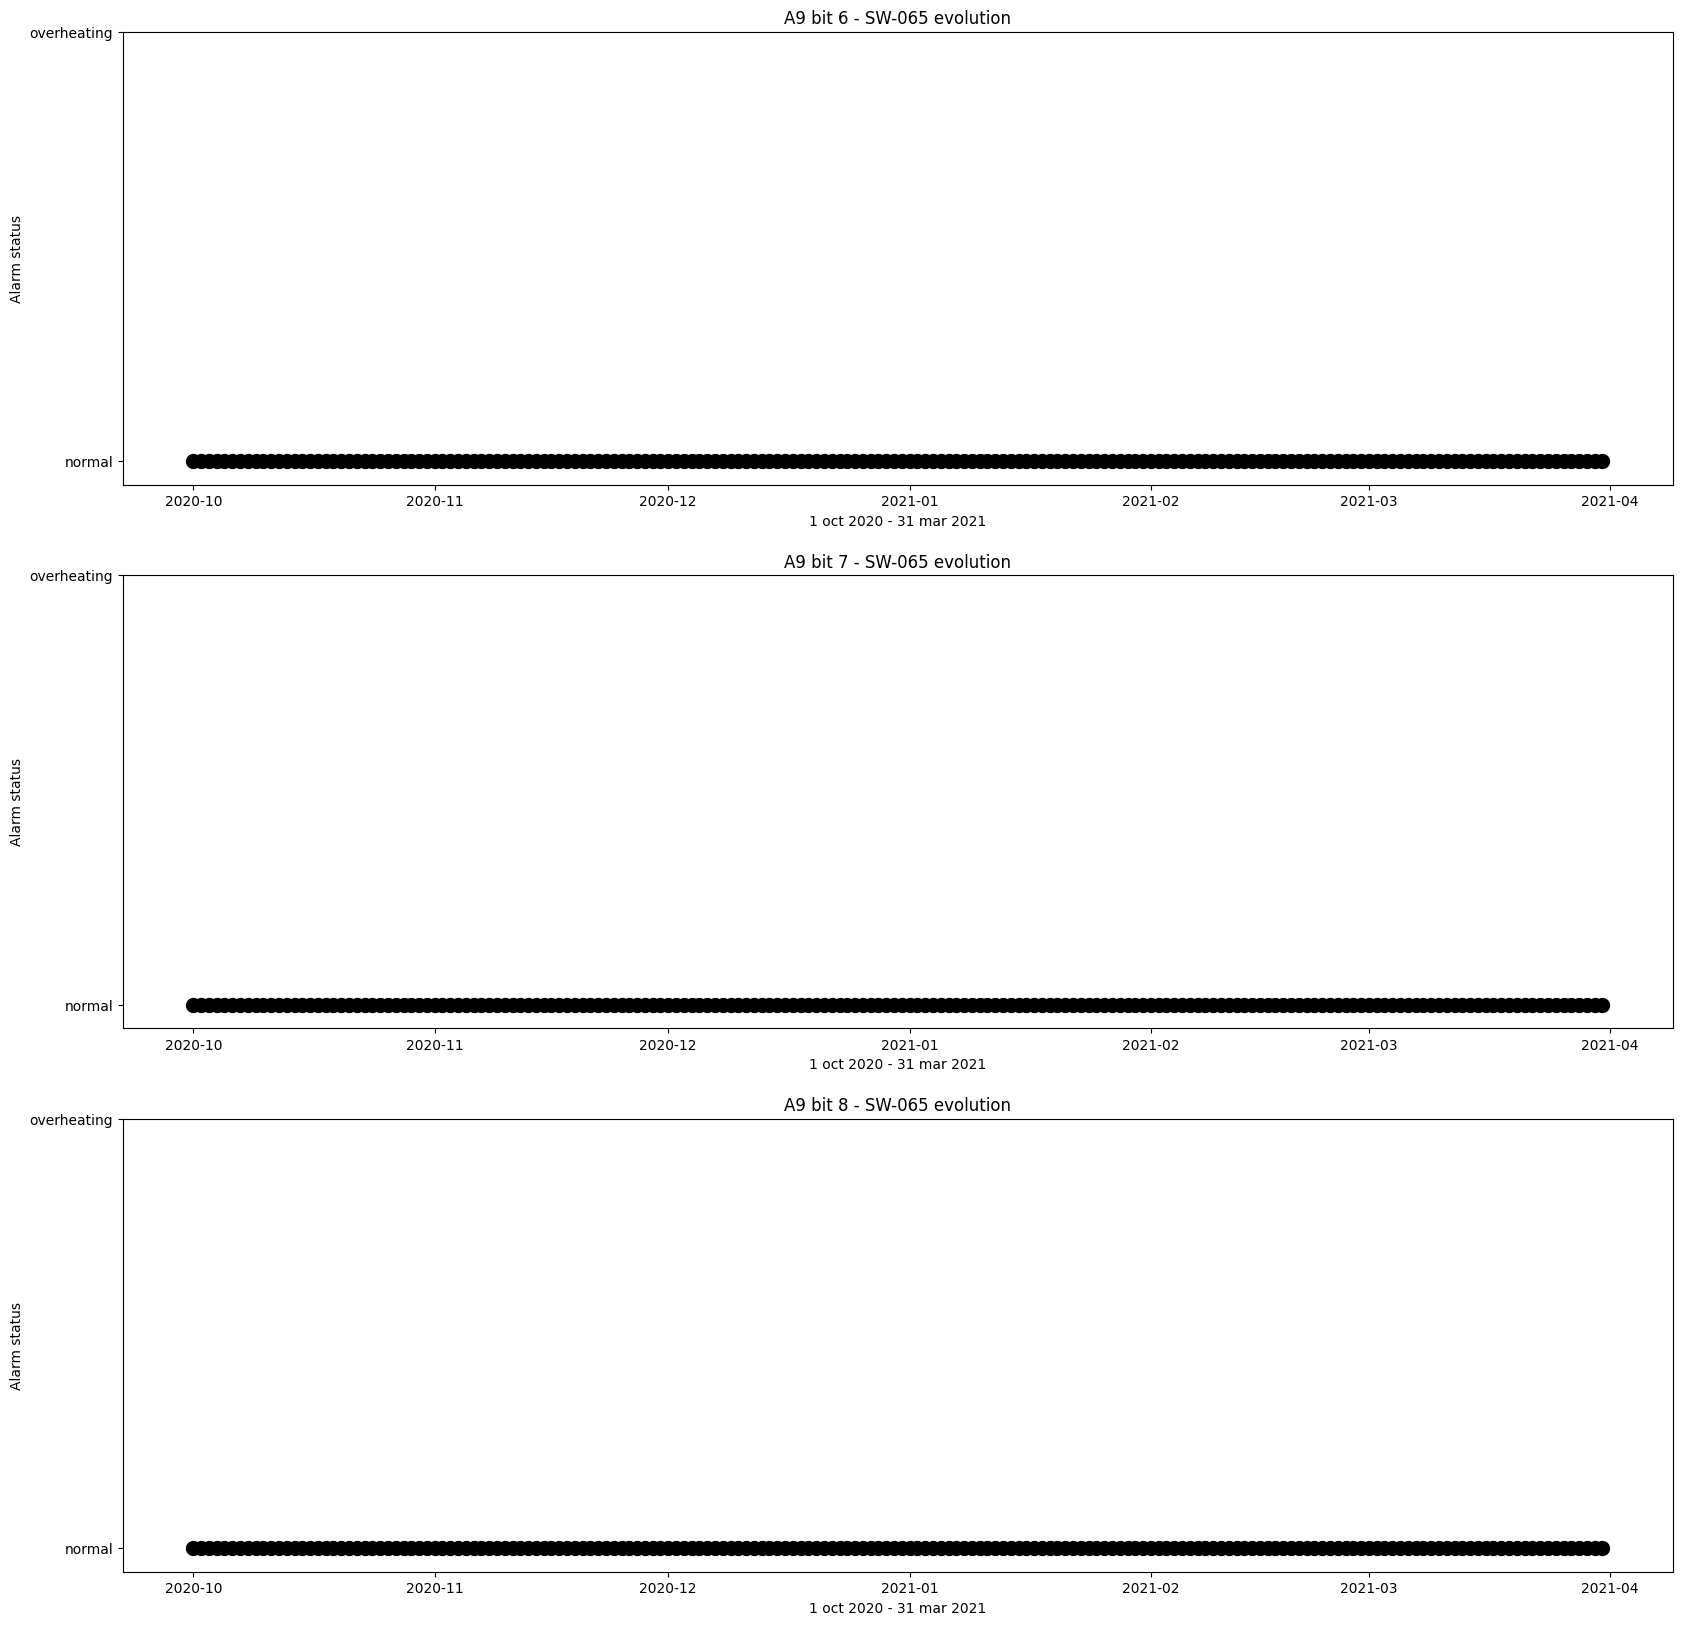

In [22]:
plotting_alarms("SW-065", "A9", SW_065_A9.toPandas())

Here, we can see that the device worked perfectly without any failure (no overheating). Then we can conclude the analysis for the device SW-106. Let's proceed to the next device.

In [23]:
# Release resources
SW_065_A9 = None

## *Device SW-088 | A5*

In [24]:
spark.sparkContext.setJobGroup("group2", "Device 4")

# First we choose the hwid SW-088 and its A5 values 
SW_088_A5 = alarms_data.filter((col("hwid") == "SW-088") & (col("metric") == "A5")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_088_A5 = all_time.join(SW_088_A5, all_time.date == SW_088_A5.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_088_A5 = SW_088_A5.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})
# Take the AND operator for analyzing the combine overheating status
SW_088_A5 = SW_088_A5.withColumn("overheating_A5", col("max_6") | col("max_7") | col("max_8"))
SW_088_A5_pd = SW_088_A5.toPandas()

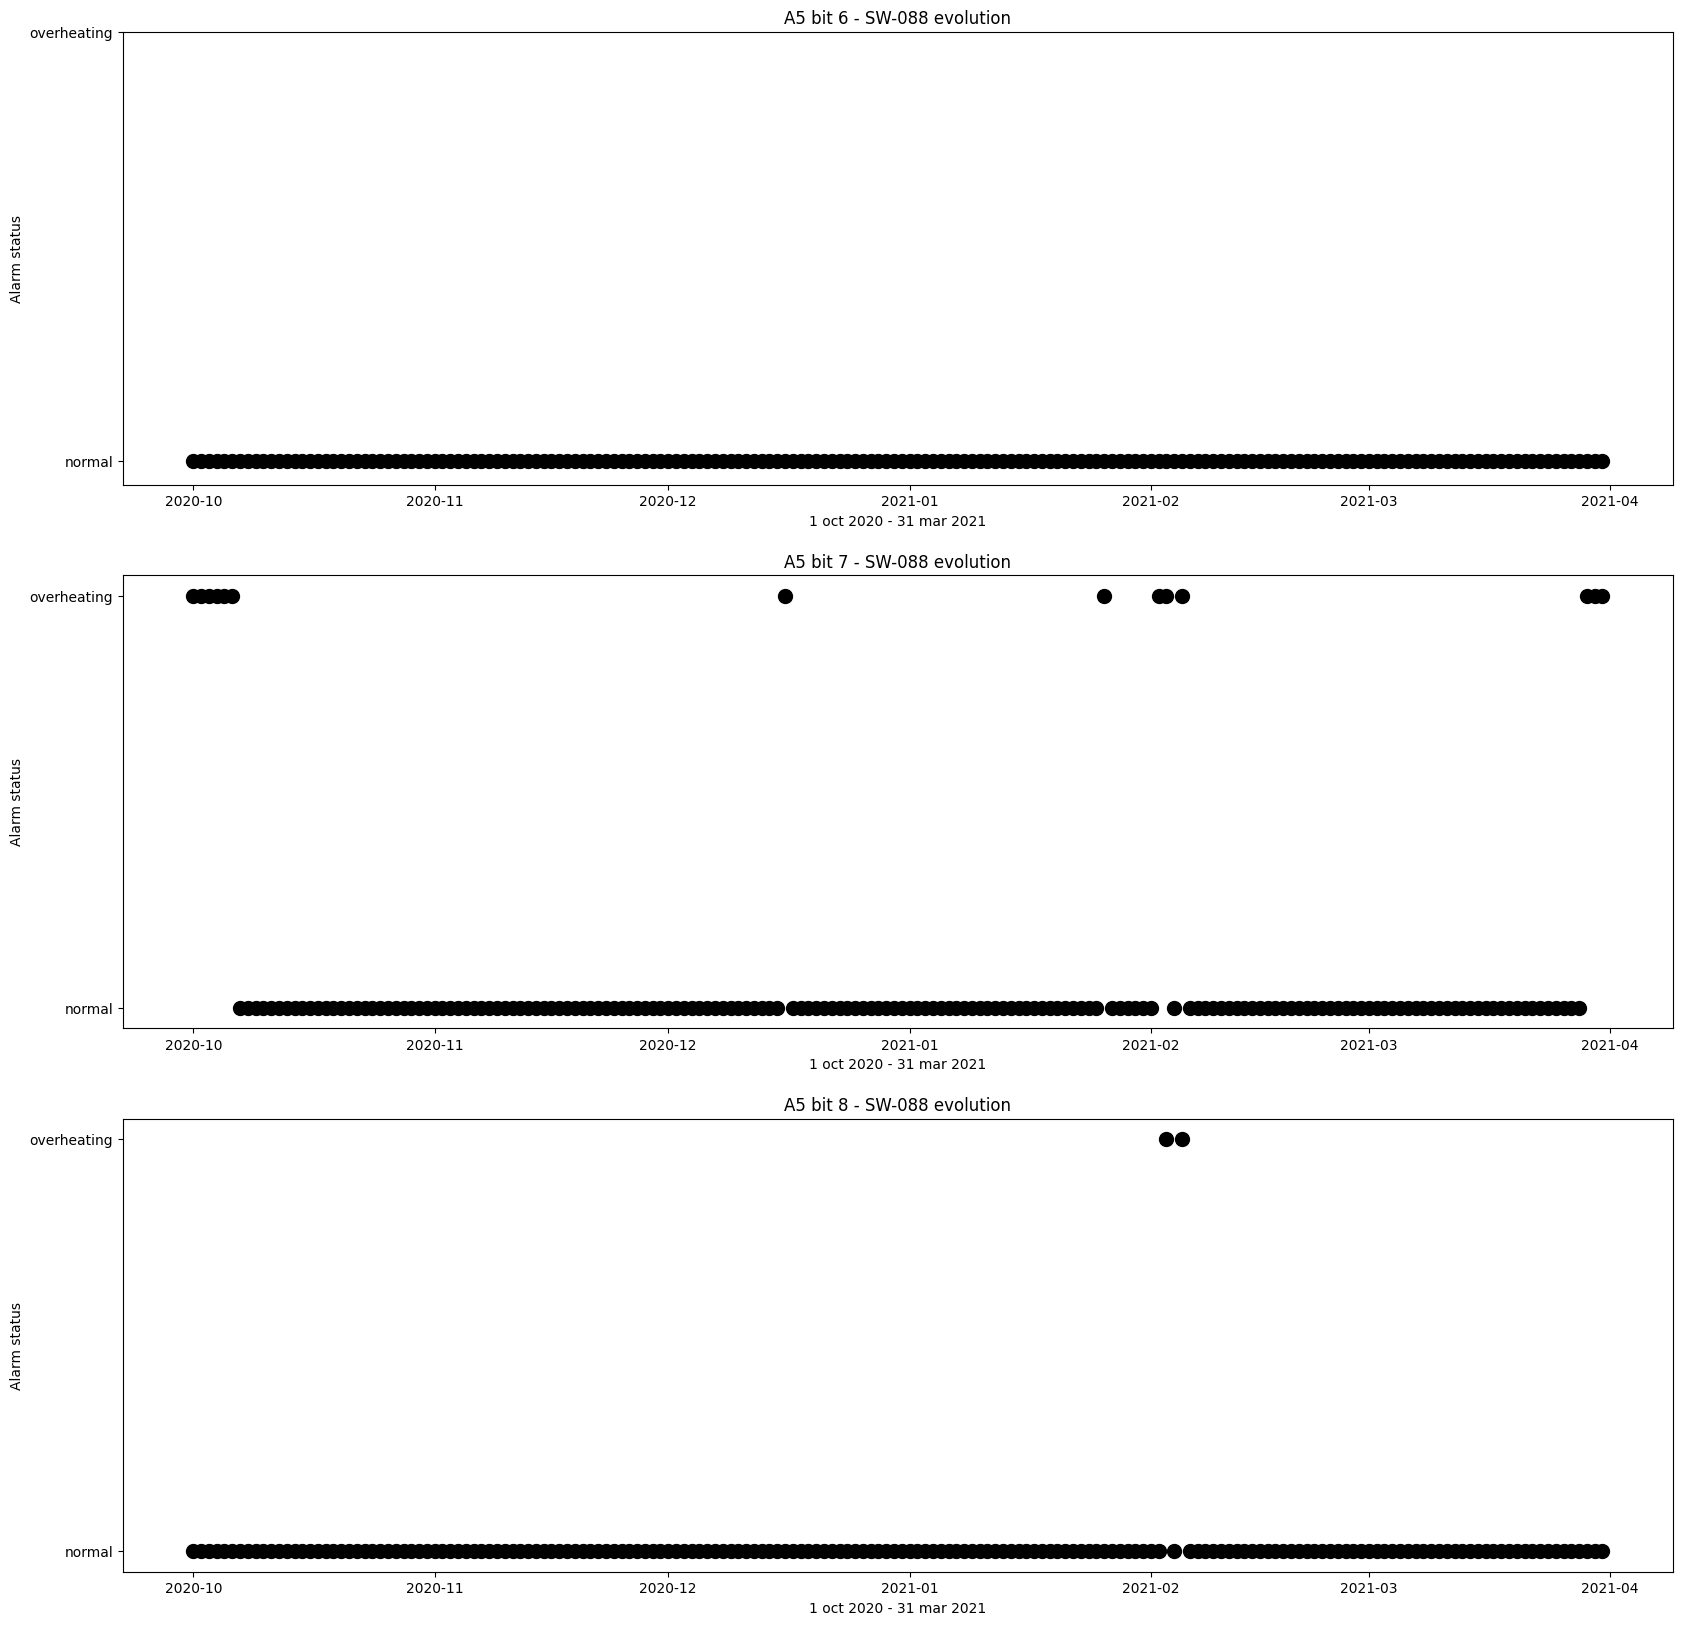

In [25]:
plotting_alarms("SW-088", "A5", SW_088_A5_pd)

Here we can see there has been some issues in the SW-088 according to A5. Now we proceed to join the data and see the combined engine status. 

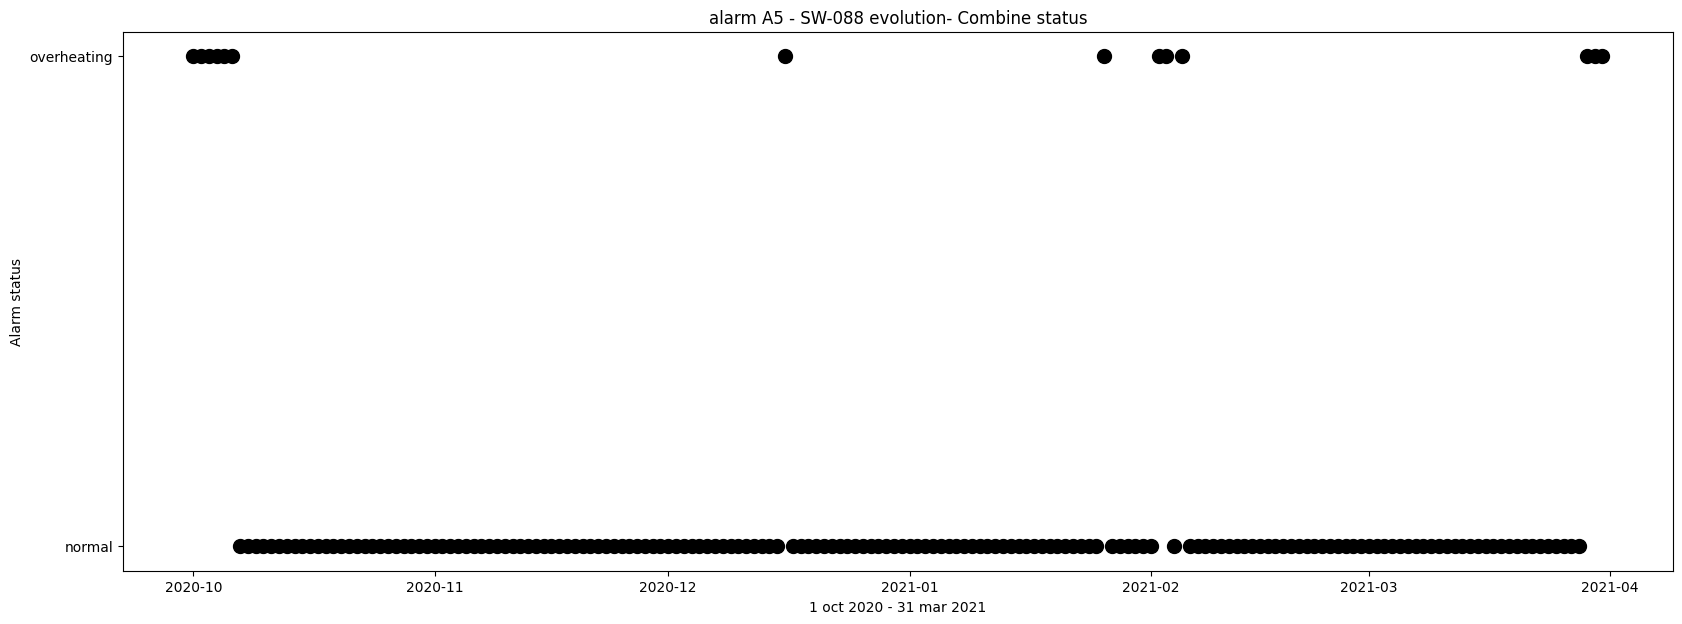

In [26]:
y_labels_alarm = np.array([0,1])
labels_alarm = ["normal", "overheating"]
fig, axis = plt.subplots(1, 1, figsize = (20,7))
    

axis.plot(SW_088_A5_pd["date"],SW_088_A5_pd["overheating_A5"], "k.", markersize=20)
axis.set_title("alarm A5 - SW-088 evolution- Combine status")
axis.set_xlabel("1 oct 2020 - 31 mar 2021")
axis.set_ylabel("Alarm status")
axis.set_yticks(y_labels_alarm, labels_alarm)

## *Device SW-088 | A9*

In [27]:
# First we choose the hwid SW-106 and its A9 values 
SW_088_A9 = alarms_data.filter((col("hwid") == "SW-088") & (col("metric") == "A9")).drop("hwid").drop("metric")
# Then we join the remained data frame with the all_time dataframe (that has all the dates from October to March)
SW_088_A9 = all_time.join(SW_088_A9, all_time.date == SW_088_A9.time, how="left")
# As there will be some dates, in which we do not have any measurement, it is assumed that the device worked perfectly so "0" value is written.
SW_088_A9 = SW_088_A9.drop("time").na.fill({'max_6': '0', 'max_7': '0', 'max_8': '0'})
SW_088_A9 = SW_088_A9.withColumn("overheating_A9", col("max_6") | col("max_7") | col("max_8"))
SW_088_A9_pd = SW_088_A9.toPandas()

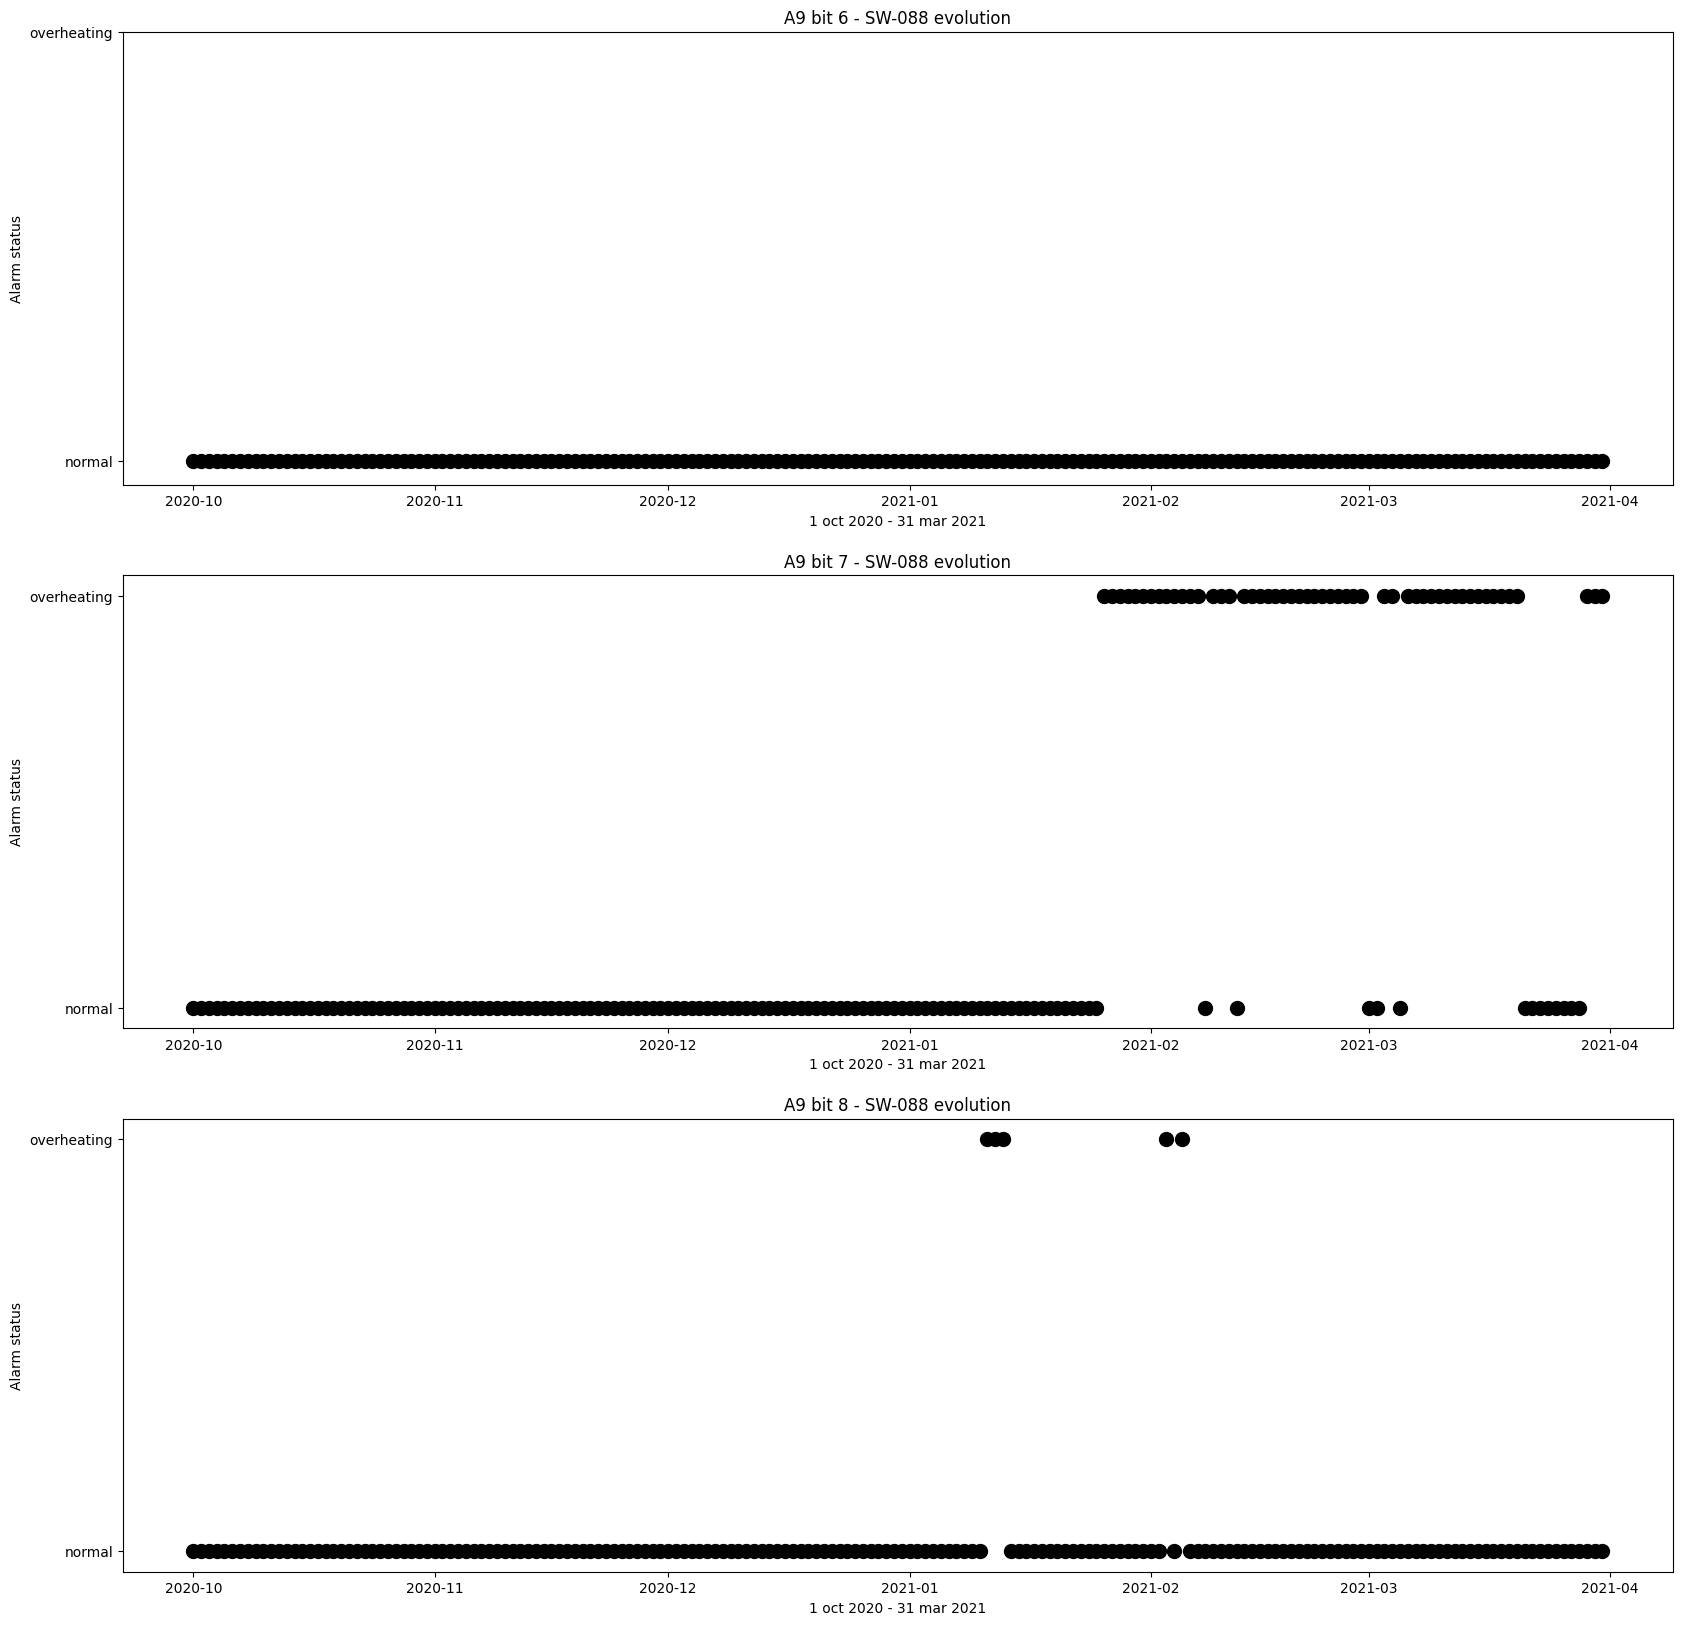

In [28]:
plotting_alarms("SW-088", "A9", SW_088_A9_pd)

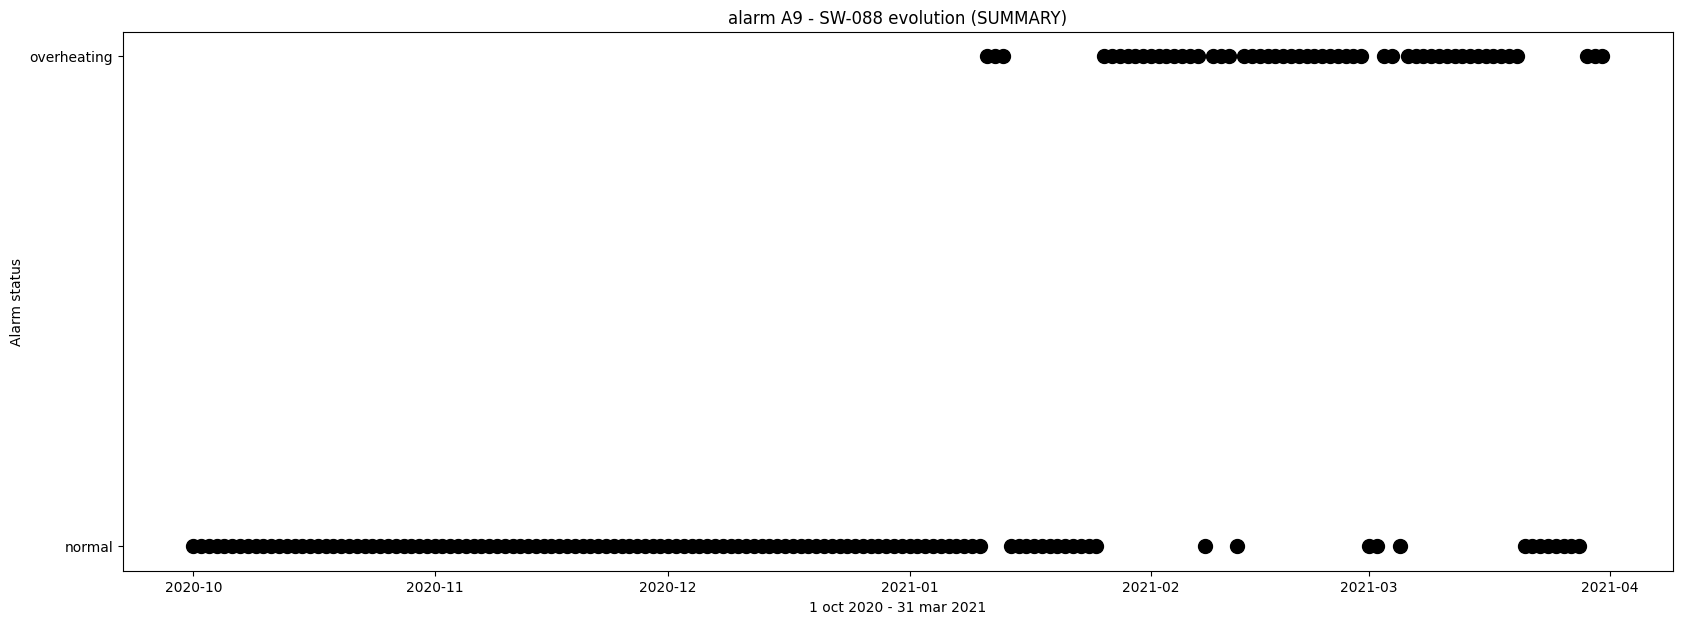

In [29]:
y_labels_alarm = np.array([0,1])
labels_alarm = ["normal", "overheating"]
fig, axis = plt.subplots(1, 1, figsize = (20,7))
    

axis.plot(SW_088_A9_pd["date"],SW_088_A9_pd["overheating_A9"], "k.", markersize=20)
axis.set_title("alarm A9 - SW-088 evolution (SUMMARY)")
axis.set_xlabel("1 oct 2020 - 31 mar 2021")
axis.set_ylabel("Alarm status")
axis.set_yticks(y_labels_alarm, labels_alarm)

## *Combine alarm status A5-A9*

Finally, let's define a overheating final status. Thiw will give us the dates in which there was an overheating in the device SW-088.

In [30]:
spark.sparkContext.setJobGroup("group2", "Device 5")


SW_088_A9 = SW_088_A9.withColumnRenamed("date", "date_A9")
SW_088_C =  SW_088_A5.join(SW_088_A9, SW_088_A5.date == SW_088_A9.date_A9, how="left")
SW_088_C =  SW_088_C.withColumn("overheating_C", col("overheating_A5") | col("overheating_A9"))
SW_088_C = SW_088_C.drop("max_6", "max_7", "max_8", "date_A9")

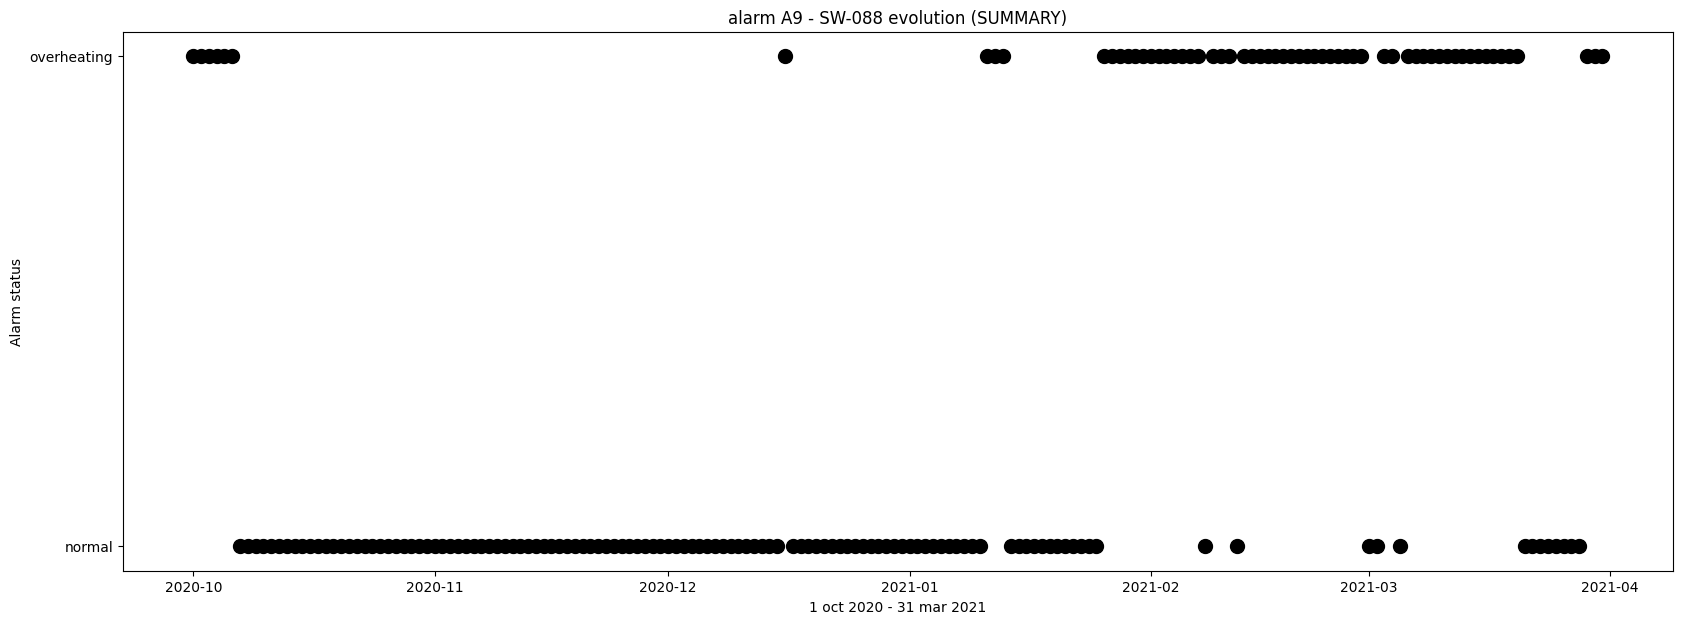

In [31]:
SW_088_pd = SW_088_C.toPandas()
y_labels_alarm = np.array([0,1])
labels_alarm = ["normal", "overheating"]
fig, axis = plt.subplots(1, 1, figsize = (20,7))
    

axis.plot(SW_088_pd["date"],SW_088_pd["overheating_C"], "k.", markersize=20)
axis.set_title("alarm A9 - SW-088 evolution (SUMMARY)")
axis.set_xlabel("1 oct 2020 - 31 mar 2021")
axis.set_ylabel("Alarm status")
axis.set_yticks(y_labels_alarm, labels_alarm)

From this analysis, we have recognized the device SW-088 shows some overheating in a few days. Then using the combine overheating status, for A5 and A9 we proceed to find correlation among these alarms and other features presented in the dataset.

# Section D: Feature Selection

First, select the data related with the SW-088 device and list all the metrics. Then we groupby all metrics into daily data. We perform this cause are alarm data A5 and A9 are sampled in that way. For grouping by; temperature, volume, porcentage values will be agregated using mean values, others will be aggregated using max function. 

## *Aggregation methods*

In [32]:
spark.sparkContext.setJobGroup("group3", "Aggregation")

# Filter values from device SW-088
SW_088_features = refined_data.filter(col("hwid") == "SW-088").drop("hwid")
#SW_088_features_names = SW_088_features.select("metric").distinct().collect()

In [33]:
# Define a dictionary which has the aggregation method we must perform for each metric.
agg_dict = {
    "A5": "max","A9": "max", "ComError": "max","P1": "max","P10": "mean","P15": "max","P16": "mean","P17": "mean","P18": "mean",
    "P2": "max","P5": "mean","P6": "mean","P7": "mean","P8": "mean","P9": "mean","S1": "max","S10": "mean","S100": "mean",
    "S101": "mean","S102": "mean","S106": "mean","S107": "mean","S108": "mean","S109": "mean","S11": "max","S110": "mean",
    "S112": "max", "S113": "max", "S114": "max", "S115": "max", "S117": "max", "S118": "max", "S122": "mean", "S123": "max",
    "S124": "mean", "S125": "mean", "S126": "max", "S127": "max", "S128": "mean", "S129": "mean", "S130": "max", "S137": "mean",
    "S138": "max", "S140": "max", "S143": "mean", "S147": "mean", "S15": "max", "S151": "mean", "S154": "max", "S157": "mean",
    "S158": "mean", "S159": "mean", "S16": "max", "S163": "mean", "S164": "mean", "S165": "mean", "S166": "mean", "S167": "mean",
    "S169": "max", "S17": "max", "S170": "max", "S171": "max", "S172": "max", "S173": "max", "S174": "max", "S175": "max", "S176": "max",
    "S178": "mean", "S179": "max", "S180": "mean", "S181": "mean", "S183": "max", "S19": "mean", "S2": "mean", "S201": "max", "S202": "max",
    "S203": "max", "S204": "max",  "S205": "max",  "S206": "max",  "S25": "max",  "S3": "mean",  "S33": "max",  "S34": "max",  "S35": "max",
    "S37": "mean",  "S39": "mean",  "S40": "mean",  "S41": "mean",  "S42": "mean",  "S43": "mean",  "S45": "mean",  "S46": "mean",  "S47": "mean",
    "S49": "mean",  "S5": "max",  "S50": "mean",  "S53": "max",  "S54": "max",  "S55": "max",  "S56": "max",  "S57": "max",  "S6": "mean",
    "S63": "max", "S64": "max",  "S69": "mean",  "S7": "max",  "S70": "mean",  "S71": "mean",  "S72": "mean",  "S73": "max",  "S8": "max",
    "S80": "mean",  "S81": "max",  "S83": "max",  "S86": "mean",  "S9": "mean",  "S90": "mean",  "S94": "mean",  "S97": "max",  "SA1": "max",
    "SA10": "max", "SA11": "max", "SA12": "max", "SA2": "max", "SA3": "max", "SA4": "max", "SA5": "max", "SA6": "max", "SA7": "max", "SA8": "max",
    "SA9": "max"}

In [34]:

# Define groupby schema
agg_exprs = []
for metric, agg_type in agg_dict.items():
    if agg_type == "mean":
        agg_exprs.append(round(mean(when(col("metric") == metric, col("value"))),1).alias(f"{metric}"))
    elif agg_type == "max":
        agg_exprs.append(mode(when(col("metric") == metric, col("value"))).alias(f"{metric}"))

# Rename column for left join
SW_088_features = SW_088_features.withColumn("time", to_date(col("time")))
# Apply groupby
SW_088_features = SW_088_features.groupBy("time").agg(*agg_exprs)
# Remove useless columns
SW_088_features = SW_088_features.drop("A5", "A9", "ComError")
# Combine dataframe with SW_088_C
SW_088_features = SW_088_C.join(SW_088_features, SW_088_C.date == SW_088_features.time, how="left").drop("time")

Then, as the dataset has decreased its size exponentially, we apply persist for accelerating calculations. Next we compute the correlation coefficient for binary classes.

In [35]:
SW_088_features = SW_088_features.fillna(0)
SW_088_features = SW_088_features.repartition(5)
SW_088_features.persist()

24/09/02 22:33:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[date: date, overheating_A5: boolean, overheating_A9: boolean, overheating_C: boolean, P1: int, P10: double, P15: int, P16: double, P17: double, P18: double, P2: int, P5: double, P6: double, P7: double, P8: double, P9: double, S1: int, S10: double, S100: double, S101: double, S102: double, S106: double, S107: double, S108: double, S109: double, S11: int, S110: double, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: double, S123: int, S124: double, S125: double, S126: int, S127: int, S128: double, S129: double, S130: int, S137: double, S138: int, S140: int, S143: double, S147: double, S15: int, S151: double, S154: int, S157: double, S158: double, S159: double, S16: int, S163: double, S164: double, S165: double, S166: double, S167: double, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: double, S179: int, S180: double, S181: double, S183: int, S19: double, S2: double, S201: int, S202: int, S203: int,

## *Point biserial correlation*

In [36]:
def correlation_values(df, binary_column):
    """
    Compute the point biserial correlation for a given dataframe

    Inputs:
        df <- dataframe <- pyspark
        binary_column <- O/1 column to be analized
    """
    corr_vals = {}

    # Calculate counts
    count_total = df.count()
    count_1 = df.filter(col(binary_column) == 1).count()
    count_0 = df.filter(col(binary_column) == 0).count()
    p = count_1 / count_total
    q = count_0 / count_total

    # Iterate over columns in the DataFrame
    for col_name in df.columns:
        if col_name not in ["date", "overheating_A5", "overheating_A9", "overheating_C"]:
            # Calculate std
            stddev_cont = df.agg(stddev(col(col_name))).first()[0]

            # Calculate mean for binary column
            mean_cont_1 = df.filter(col(binary_column) == 1).agg(mean(col(col_name))).first()[0]
            mean_cont_0 = df.filter(col(binary_column) == 0).agg(mean(col(col_name))).first()[0]

            # Calculate point biserial correlation
            if stddev_cont!= 0:
                point_biserial_corr = ((mean_cont_1 - mean_cont_0)* (p * q)**0.5) / (stddev_cont)

            # Store correlation value in dictionary
            corr_vals[col_name] = point_biserial_corr

    return corr_vals

Given the computed values, select the top 10, including possitive and negative correlations.

In [37]:
spark.sparkContext.setJobGroup("group3", "Correlation")

# Compute coefficients with respect to overheating C
coefficient_vals = correlation_values(SW_088_features, "overheating_C")
# Take the metric with the biggest values (most correlated)
ordered_vals = sorted(coefficient_vals.items(), key=lambda x: x[1], reverse=True)
most_correlated = ordered_vals[:5] + ordered_vals[-5:]
corr_keys = [item[0] for item in most_correlated]
corr_vals = [np.round(item[1],2) for item in most_correlated]
SW_088_features = SW_088_features.select(corr_keys + ["overheating_C", "date"])

Highest correlated values are:

In [38]:
print(corr_keys)

['S53', 'S54', 'S7', 'S172', 'S3', 'S19', 'S173', 'S174', 'S175', 'S176']


## *Correlated features*

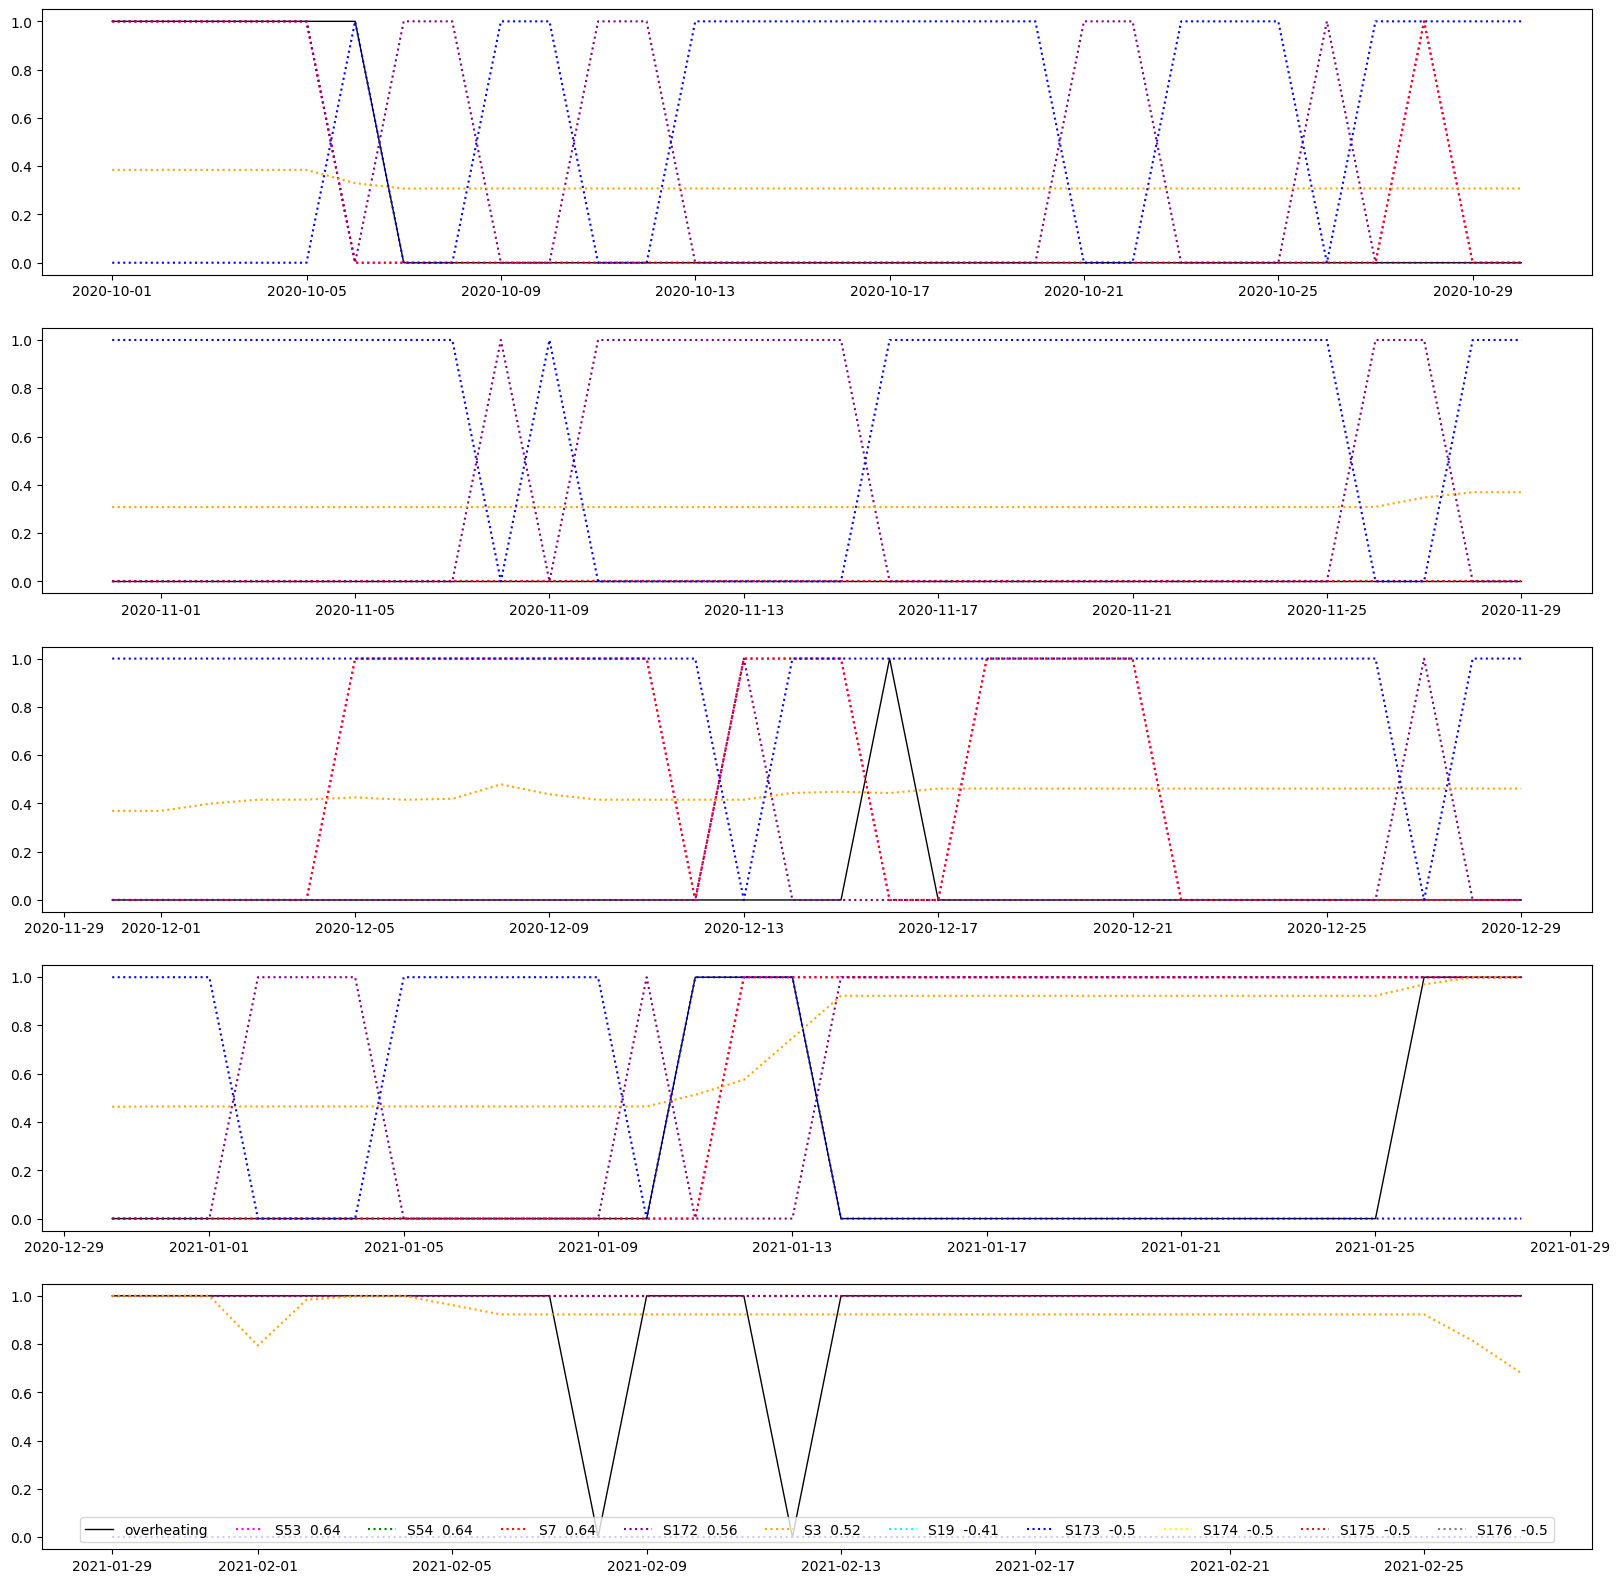

In [39]:
# Create pandas for plotting
SW_088_features_pd = SW_088_features.orderBy("date").toPandas()
# Define colors for plotting different windows (one month per plot)
colors = ["magenta", "green", "red", "purple", "orange", "cyan", "blue", "yellow", "brown", "gray"]
s = 0
d = 30
fig, axis = plt.subplots(5,1, figsize=(20,20))
for plot in range(5):
    axis[plot].plot(SW_088_features_pd["date"][s:s+d],SW_088_features_pd["overheating_C"][s:s+d], linewidth=1, label = "overheating", color ="black")
    for idx, ky in enumerate(corr_keys):
        axis[plot].plot(SW_088_features_pd["date"][s:s+d],SW_088_features_pd[ky][s:s+d]/np.max(SW_088_features_pd[ky]),
                        label = ky +"  "+ str(corr_vals[idx]), color = colors[idx], linestyle = 'dotted')
    s = s + d
axis[plot].legend(loc="lower center", ncol = 11)


# Section E: Failure prediction

For predicting the behaviour and a possible overheating, first it will be analized the possitive correlation before the overheating of the device.

## *Possitive correlation*

Applying a general method for analyzing a possible predition method we may infer the following:

**Before the engine gets an overheating, S7 and S172 gets activated** <br>
**S3 values get higher before and during an overheating of the device** <br>
**Aditionally, S3 values are shifted 5 days (before) from the overheating alarm**


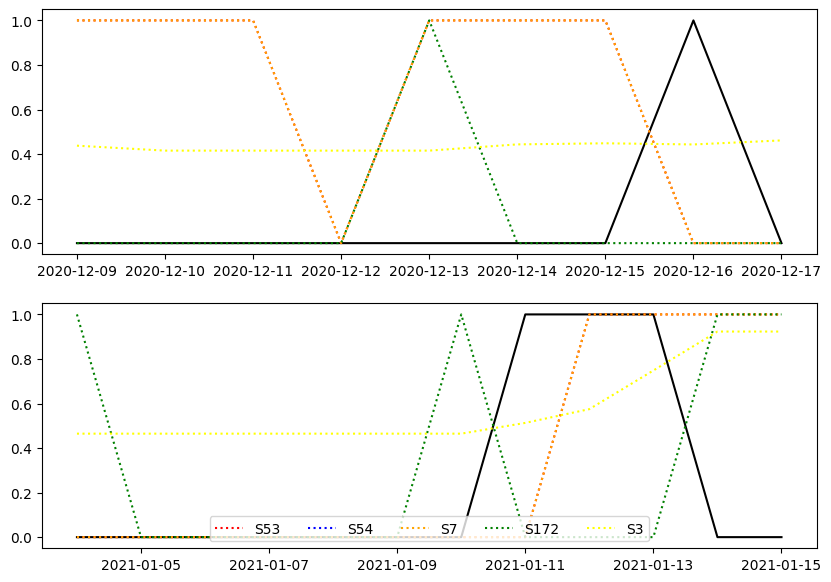

In [40]:
spark.sparkContext.setJobGroup("group4", "Analysis")
pos_cor = ["S53", "S54", "S7", "S172", "S3"]
colors = ["red", "blue", "orange", "green", "yellow"]
time_slot = [np.arange(69,78), np.arange(95, 107)]


fig, axis = plt.subplots(2,1, figsize=(10,7))
for i in range(2):
    axis[i].plot(SW_088_features_pd["date"][time_slot[i]], SW_088_features_pd["overheating_C"][time_slot[i]], color = "black")

    for j in range(5): 
        axis[i].plot(SW_088_features_pd["date"][time_slot[i]], SW_088_features_pd[pos_cor[j]][time_slot[i]]/np.max(SW_088_features_pd[pos_cor[j]]), color = colors[j], linestyle = 'dotted', label = pos_cor[j])
axis[i].legend(loc="lower center", ncol = 11)


## *Negative correlation*

Applying a general method for analyzing a possible predition method we may infer the following:

**Before the engine gets an overheating, S173 status gets 0**

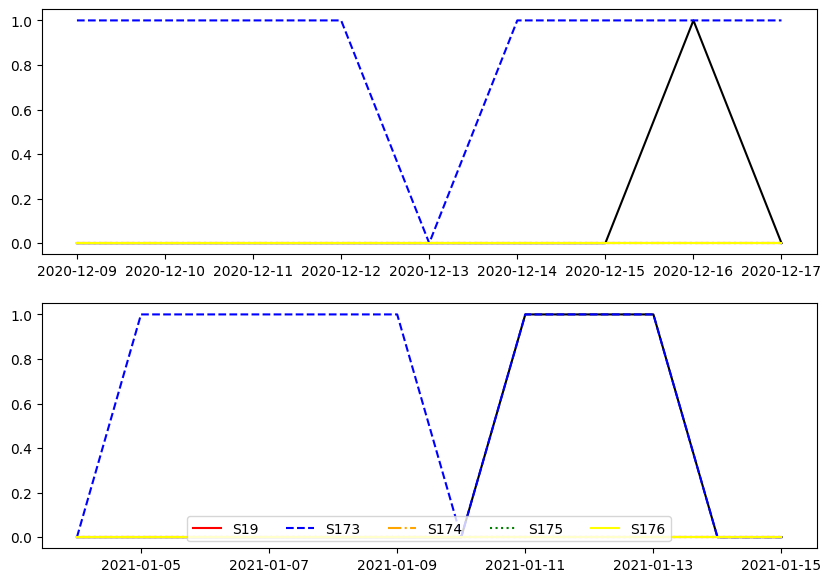

In [41]:
spark.sparkContext.setJobGroup("group4", "Analysis")
pos_cor = ["S19", "S173", "S174", "S175", "S176"]
colors = ["red", "blue", "orange", "green", "yellow"]
line_style = ["-", "--", "-.", ":", "-"]
time_slot = [np.arange(69,78), np.arange(95, 107)]


fig, axis = plt.subplots(2,1, figsize=(10,7))
for i in range(2):
    axis[i].plot(SW_088_features_pd["date"][time_slot[i]], SW_088_features_pd["overheating_C"][time_slot[i]], color = "black")

    for j in range(5): 
        axis[i].plot(SW_088_features_pd["date"][time_slot[i]], SW_088_features_pd[pos_cor[j]][time_slot[i]], color = colors[j], linestyle = line_style[j], label = pos_cor[j])
axis[i].legend(loc="lower center", ncol = 11)

*To summary, we may say that*:<br>
There might be an overheating in a device if: 
S7 and S172, S3 turn on and S173 turns off. <br>
Then, when these signals appear, a maintanance must be done.
